# Import packages & functions

In [1]:
import os
import sys
import json
import argparse
import numpy as np
import math
from einops import rearrange
import time
import random
import string
import h5py
from tqdm import tqdm
import webdataset as wds
import gc

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms
from accelerate import Accelerator

# SDXL unCLIP requires code from https://github.com/Stability-AI/generative-models/tree/main
sys.path.append('generative_models/')
import sgm
from generative_models.sgm.modules.encoders.modules import FrozenOpenCLIPImageEmbedder # bigG embedder

# tf32 data type is faster than standard float32
torch.backends.cuda.matmul.allow_tf32 = True

# custom functions #
import utils

In [2]:
### Multi-GPU config ###
local_rank = os.getenv('RANK')
if local_rank is None: 
    local_rank = 0
else:
    local_rank = int(local_rank)
print("LOCAL RANK ", local_rank)  

data_type = torch.float16 # change depending on your mixed_precision
num_devices = torch.cuda.device_count()
if num_devices==0: num_devices = 1

# First use "accelerate config" in terminal and setup using deepspeed stage 2 with CPU offloading!
accelerator = Accelerator(split_batches=False, mixed_precision="fp16")
if utils.is_interactive(): # set batch size here if using interactive notebook instead of submitting job
    global_batch_size = batch_size = 8
else:
    global_batch_size = os.environ["GLOBAL_BATCH_SIZE"]
    batch_size = int(os.environ["GLOBAL_BATCH_SIZE"]) // num_devices

LOCAL RANK  0


In [3]:
print("PID of this process =",os.getpid())
device = accelerator.device
print("device:",device)
world_size = accelerator.state.num_processes
distributed = not accelerator.state.distributed_type == 'NO'
num_devices = torch.cuda.device_count()
if num_devices==0 or not distributed: num_devices = 1
num_workers = num_devices
print(accelerator.state)

print("distributed =",distributed, "num_devices =", num_devices, "local rank =", local_rank, "world size =", world_size, "data_type =", data_type)
print = accelerator.print # only print if local_rank=0

PID of this process = 2728105
device: cuda
Distributed environment: DistributedType.NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

distributed = False num_devices = 1 local rank = 0 world size = 1 data_type = torch.float16


# Configurations

In [4]:
# if running this interactively, can specify jupyter_args here for argparser to use
if utils.is_interactive():
    model_name = "base"
    print("model_name:", model_name)
    
    # global_batch_size and batch_size should already be defined in the 2nd cell block
    jupyter_args = f"--data_path=/weka/proj-fmri/shared/mindeyev2_dataset \
                    --cache_dir=/weka/proj-fmri/shared/cache \
                    --model_name={model_name} \
                    --no-multi_subject --subj=1 --batch_size={batch_size} --num_sessions=3 \
                    --hidden_dim=1024 --clip_scale=1. \
                    --no-blurry_recon --blur_scale=.5  \
                    --seq_past=0 --seq_future=0 \
                    --use_prior --prior_scale=30 \
                    --n_blocks=4 --max_lr=3e-4 --mixup_pct=.33 --num_epochs=150 --no-use_image_aug \
                    --ckpt_interval=1 --ckpt_saving --wandb_log"

    print(jupyter_args)
    jupyter_args = jupyter_args.split()
    
    from IPython.display import clear_output # function to clear print outputs in cell
    %load_ext autoreload 
    # this allows you to change functions in models.py or utils.py and have this notebook automatically update with your revisions
    %autoreload 2 

model_name: base
--data_path=/weka/proj-fmri/shared/mindeyev2_dataset                     --cache_dir=/weka/proj-fmri/shared/cache                     --model_name=base                     --no-multi_subject --subj=1 --batch_size=8 --num_sessions=3                     --hidden_dim=1024 --clip_scale=1.                     --no-blurry_recon --blur_scale=.5                      --seq_past=0 --seq_future=0                     --use_prior --prior_scale=30                     --n_blocks=4 --max_lr=3e-4 --mixup_pct=.33 --num_epochs=150 --no-use_image_aug                     --ckpt_interval=1 --ckpt_saving --wandb_log --multisubject_ckpt=../train_logs/multisubject_subj01_1024_24bs_nolow


In [5]:
parser = argparse.ArgumentParser(description="Model Training Configuration")
parser.add_argument(
    "--model_name", type=str, default="testing",
    help="name of model, used for ckpt saving and wandb logging (if enabled)",
)
parser.add_argument(
    "--data_path", type=str, default=os.getcwd(),
    help="Path to where NSD data is stored / where to download it to",
)
parser.add_argument(
    "--cache_dir", type=str, default=os.getcwd(),
    help="Path to where misc. files downloaded from huggingface are stored. Defaults to current src directory.",
)
parser.add_argument(
    "--subj",type=int, default=1, choices=[1,2,3,4,5,6,7,8],
    help="Validate on which subject?",
)
parser.add_argument(
    "--multisubject_ckpt", type=str, default=None,
    help="Path to pre-trained multisubject model to finetune a single subject from. multisubject must be False.",
)
parser.add_argument(
    "--num_sessions", type=int, default=1,
    help="Number of training sessions to include",
)
parser.add_argument(
    "--use_prior",action=argparse.BooleanOptionalAction,default=True,
    help="whether to train diffusion prior (True) or just rely on retrieval part of the pipeline (False)",
)
parser.add_argument(
    "--visualize_prior",action=argparse.BooleanOptionalAction,default=False,
    help="output visualizations from unCLIP every ckpt_interval (requires much more memory!)",
)
parser.add_argument(
    "--batch_size", type=int, default=16,
    help="Batch size can be increased by 10x if only training retreival submodule and not diffusion prior",
)
parser.add_argument(
    "--wandb_log",action=argparse.BooleanOptionalAction,default=False,
    help="whether to log to wandb",
)
parser.add_argument(
    "--resume_from_ckpt",action=argparse.BooleanOptionalAction,default=False,
    help="if not using wandb and want to resume from a ckpt",
)
parser.add_argument(
    "--wandb_project",type=str,default="stability",
    help="wandb project name",
)
parser.add_argument(
    "--mixup_pct",type=float,default=.33,
    help="proportion of way through training when to switch from BiMixCo to SoftCLIP",
)
parser.add_argument(
    "--blurry_recon",action=argparse.BooleanOptionalAction,default=True,
    help="whether to output blurry reconstructions",
)
parser.add_argument(
    "--blur_scale",type=float,default=.5,
    help="multiply loss from blurry recons by this number",
)
parser.add_argument(
    "--clip_scale",type=float,default=1.,
    help="multiply contrastive loss by this number",
)
parser.add_argument(
    "--prior_scale",type=float,default=30,
    help="multiply diffusion prior loss by this",
)
parser.add_argument(
    "--use_image_aug",action=argparse.BooleanOptionalAction,default=False,
    help="whether to use image augmentation",
)
parser.add_argument(
    "--num_epochs",type=int,default=150,
    help="number of epochs of training",
)
parser.add_argument(
    "--multi_subject",action=argparse.BooleanOptionalAction,default=False,
)
parser.add_argument(
    "--new_test",action=argparse.BooleanOptionalAction,default=True,
)
parser.add_argument(
    "--n_blocks",type=int,default=4,
)
parser.add_argument(
    "--hidden_dim",type=int,default=1024,
)
parser.add_argument(
    "--seq_past",type=int,default=0,
)
parser.add_argument(
    "--seq_future",type=int,default=0,
)
parser.add_argument(
    "--lr_scheduler_type",type=str,default='cycle',choices=['cycle','linear'],
)
parser.add_argument(
    "--ckpt_saving",action=argparse.BooleanOptionalAction,default=True,
)
parser.add_argument(
    "--ckpt_interval",type=int,default=5,
    help="save backup ckpt and reconstruct every x epochs",
)
parser.add_argument(
    "--seed",type=int,default=42,
)
parser.add_argument(
    "--max_lr",type=float,default=3e-4,
)

if utils.is_interactive():
    args = parser.parse_args(jupyter_args)
else:
    args = parser.parse_args()

# create global variables without the args prefix
for attribute_name in vars(args).keys():
    globals()[attribute_name] = getattr(args, attribute_name)
    
# seed all random functions
utils.seed_everything(seed)

outdir = os.path.abspath(f'../train_logs/{model_name}')
if not os.path.exists(outdir) and ckpt_saving:
    os.makedirs(outdir,exist_ok=True)
    
if use_image_aug or blurry_recon:
    import kornia
    from kornia.augmentation.container import AugmentationSequential
if use_image_aug:
    img_augment = AugmentationSequential(
        kornia.augmentation.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1, p=0.3),
        same_on_batch=False,
        data_keys=["input"],
    )
    
if multi_subject:
    subj_list = np.arange(1,9)
    subj_list = subj_list[subj_list != subj]
else:
    subj_list = [subj]

print("subj_list", subj_list, "num_sessions", num_sessions)

subj_list [1] num_sessions 3


# Prep data, models, and dataloaders

### Creating wds dataloader, preload betas and all 73k possible images

In [6]:
def my_split_by_node(urls): return urls
num_voxels_list = []

if multi_subject:
    nsessions_allsubj=np.array([40, 40, 32, 30, 40, 32, 40, 30])
    num_samples_per_epoch = (750*40) // num_devices 
else:
    num_samples_per_epoch = (750*num_sessions) // num_devices 

print("dividing batch size by subj_list, which will then be concatenated across subj during training...") 
batch_size = batch_size // len(subj_list)

num_iterations_per_epoch = num_samples_per_epoch // (batch_size*len(subj_list))

print("batch_size =", batch_size, "num_iterations_per_epoch =",num_iterations_per_epoch, "num_samples_per_epoch =",num_samples_per_epoch)

dividing batch size by subj_list, which will then be concatenated across subj during training...
batch_size = 8 num_iterations_per_epoch = 281 num_samples_per_epoch = 2250


In [7]:
train_data = {}
train_dl = {}
num_voxels = {}
voxels = {}
for s in subj_list:
    print(f"Training with {num_sessions} sessions")
    if multi_subject:
        train_url = f"{data_path}/wds/subj0{s}/train/" + "{0.." + f"{nsessions_allsubj[s-1]-1}" + "}.tar"
    else:
        train_url = f"{data_path}/wds/subj0{s}/train/" + "{0.." + f"{num_sessions-1}" + "}.tar"
    print(train_url)
    
    train_data[f'subj0{s}'] = wds.WebDataset(train_url,resampled=True,nodesplitter=my_split_by_node)\
                        .shuffle(750, initial=1500, rng=random.Random(42))\
                        .decode("torch")\
                        .rename(behav="behav.npy", past_behav="past_behav.npy", future_behav="future_behav.npy", olds_behav="olds_behav.npy")\
                        .to_tuple(*["behav", "past_behav", "future_behav", "olds_behav"])
    train_dl[f'subj0{s}'] = torch.utils.data.DataLoader(train_data[f'subj0{s}'], batch_size=batch_size, shuffle=False, drop_last=True, pin_memory=True)

    f = h5py.File(f'{data_path}/betas_all_subj0{s}_fp32_renorm.hdf5', 'r')
    betas = f['betas'][:]
    betas = torch.Tensor(betas).to("cpu").to(data_type)
    num_voxels_list.append(betas[0].shape[-1])
    num_voxels[f'subj0{s}'] = betas[0].shape[-1]
    voxels[f'subj0{s}'] = betas
    print(f"num_voxels for subj0{s}: {num_voxels[f'subj0{s}']}")

print("Loaded all subj train dls and betas!\n")

# Validate only on one subject
if multi_subject: 
    subj = subj_list[0] # cant validate on the actual held out person so picking first in subj_list
if not new_test: # using old test set from before full dataset released (used in original MindEye paper)
    if subj==3:
        num_test=2113
    elif subj==4:
        num_test=1985
    elif subj==6:
        num_test=2113
    elif subj==8:
        num_test=1985
    else:
        num_test=2770
    test_url = f"{data_path}/wds/subj0{subj}/test/" + "0.tar"
elif new_test: # using larger test set from after full dataset released
    if subj==3:
        num_test=2371
    elif subj==4:
        num_test=2188
    elif subj==6:
        num_test=2371
    elif subj==8:
        num_test=2188
    else:
        num_test=3000
    test_url = f"{data_path}/wds/subj0{subj}/new_test/" + "0.tar"
print(test_url)
test_data = wds.WebDataset(test_url,resampled=False,nodesplitter=my_split_by_node)\
                    .shuffle(750, initial=1500, rng=random.Random(42))\
                    .decode("torch")\
                    .rename(behav="behav.npy", past_behav="past_behav.npy", future_behav="future_behav.npy", olds_behav="olds_behav.npy")\
                    .to_tuple(*["behav", "past_behav", "future_behav", "olds_behav"])
test_dl = torch.utils.data.DataLoader(test_data, batch_size=num_test, shuffle=False, drop_last=True, pin_memory=True)
print(f"Loaded test dl for subj{subj}!\n")

seq_len = seq_past + 1 + seq_future
print(f"currently using {seq_len} seq_len (chose {seq_past} past behav and {seq_future} future behav)")

Training with 3 sessions
/weka/proj-fmri/shared/mindeyev2_dataset/wds/subj01/train/{0..2}.tar
num_voxels for subj01: 15724
Loaded all subj train dls and betas!

/weka/proj-fmri/shared/mindeyev2_dataset/wds/subj01/new_test/0.tar
Loaded test dl for subj1!

currently using 1 seq_len (chose 0 past behav and 0 future behav)


In [8]:
# Load 73k NSD images
f = h5py.File(f'{data_path}/coco_images_224_float16.hdf5', 'r')
images = f['images'][:] # if you go OOM you can remove the [:] so it isnt preloaded to cpu! (will require a few edits elsewhere tho)
images = torch.Tensor(images).to("cpu").to(data_type)
print("Loaded all 73k possible NSD images to cpu!", images.shape)

Loaded all 73k possible NSD images to cpu! torch.Size([73000, 3, 224, 224])


## Load models

### CLIP image embeddings  model

In [9]:
clip_img_embedder = FrozenOpenCLIPImageEmbedder(
    arch="ViT-bigG-14",
    version="laion2b_s39b_b160k",
    output_tokens=True,
    only_tokens=True,
)
clip_img_embedder.to(device)

clip_seq_dim = 256
clip_emb_dim = 1664

open_clip_pytorch_model.bin:   0%|          | 0.00/10.2G [00:00<?, ?B/s]

### SD VAE

In [10]:
if blurry_recon:
    from diffusers import AutoencoderKL    
    autoenc = AutoencoderKL(
        down_block_types=['DownEncoderBlock2D', 'DownEncoderBlock2D', 'DownEncoderBlock2D', 'DownEncoderBlock2D'],
        up_block_types=['UpDecoderBlock2D', 'UpDecoderBlock2D', 'UpDecoderBlock2D', 'UpDecoderBlock2D'],
        block_out_channels=[128, 256, 512, 512],
        layers_per_block=2,
        sample_size=256,
    )
    ckpt = torch.load(f'{cache_dir}/sd_image_var_autoenc.pth')
    autoenc.load_state_dict(ckpt)
    
    autoenc.eval()
    autoenc.requires_grad_(False)
    autoenc.to(device)
    utils.count_params(autoenc)
    
    from autoencoder.convnext import ConvnextXL
    cnx = ConvnextXL(f'{cache_dir}/convnext_xlarge_alpha0.75_fullckpt.pth')
    cnx.requires_grad_(False)
    cnx.eval()
    cnx.to(device)
    
    mean = torch.tensor([0.485, 0.456, 0.406]).to(device).reshape(1,3,1,1)
    std = torch.tensor([0.228, 0.224, 0.225]).to(device).reshape(1,3,1,1)
    
    blur_augs = AugmentationSequential(
        kornia.augmentation.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1, p=0.8),
        kornia.augmentation.RandomGrayscale(p=0.1),
        kornia.augmentation.RandomSolarize(p=0.1),
        kornia.augmentation.RandomResizedCrop((224,224), scale=(.9,.9), ratio=(1,1), p=1.0),
        data_keys=["input"],
    )

### MindEye modules

In [11]:
class MindEyeModule(nn.Module):
    def __init__(self):
        super(MindEyeModule, self).__init__()
    def forward(self, x):
        return x
        
model = MindEyeModule()
model

MindEyeModule()

In [12]:
class RidgeRegression(torch.nn.Module):
    # make sure to add weight_decay when initializing optimizer
    def __init__(self, input_sizes, out_features, seq_len): 
        super(RidgeRegression, self).__init__()
        self.out_features = out_features
        self.linears = torch.nn.ModuleList([
                torch.nn.Linear(input_size, out_features) for input_size in input_sizes
            ])
    def forward(self, x, subj_idx):
        out = torch.cat([self.linears[subj_idx](x[:,seq]).unsqueeze(1) for seq in range(seq_len)], dim=1)
        return out
        
model.ridge = RidgeRegression(num_voxels_list, out_features=hidden_dim, seq_len=seq_len)
utils.count_params(model.ridge)
utils.count_params(model)

# test on subject 1 with fake data
b = torch.randn((2,seq_len,num_voxels_list[0]))
print(b.shape, model.ridge(b,0).shape)

param counts:
16,102,400 total
16,102,400 trainable
param counts:
16,102,400 total
16,102,400 trainable
torch.Size([2, 1, 15724]) torch.Size([2, 1, 1024])


In [14]:
from models import BrainNetwork
model.backbone = BrainNetwork(h=hidden_dim, in_dim=hidden_dim, seq_len=seq_len, n_blocks=n_blocks,
                          clip_size=clip_emb_dim, out_dim=clip_emb_dim*clip_seq_dim, 
                          blurry_recon=blurry_recon, clip_scale=clip_scale)
utils.count_params(model.backbone)
utils.count_params(model)

# test that the model works on some fake data
b = torch.randn((2,seq_len,hidden_dim))
print("b.shape",b.shape)

backbone_, clip_, blur_ = model.backbone(b)
print(backbone_.shape, clip_.shape, blur_[0].shape, blur_[1].shape)

param counts:
453,360,280 total
453,360,280 trainable
param counts:
469,462,680 total
469,462,680 trainable
b.shape torch.Size([2, 1, 1024])
torch.Size([2, 256, 1664]) torch.Size([2, 256, 1664]) torch.Size([1]) torch.Size([1])


### Adding diffusion prior + unCLIP if use_prior=True

In [15]:
if use_prior:
    from models import *

    # setup diffusion prior network
    out_dim = clip_emb_dim
    depth = 6
    dim_head = 52
    heads = clip_emb_dim//52 # heads * dim_head = clip_emb_dim
    timesteps = 100

    prior_network = PriorNetwork(
            dim=out_dim,
            depth=depth,
            dim_head=dim_head,
            heads=heads,
            causal=False,
            num_tokens = clip_seq_dim,
            learned_query_mode="pos_emb"
        )

    model.diffusion_prior = BrainDiffusionPrior(
        net=prior_network,
        image_embed_dim=out_dim,
        condition_on_text_encodings=False,
        timesteps=timesteps,
        cond_drop_prob=0.2,
        image_embed_scale=None,
    )
    
    utils.count_params(model.diffusion_prior)
    utils.count_params(model)
    
    # prep unCLIP
    if visualize_prior:
        from generative_models.sgm.models.diffusion import DiffusionEngine
        from omegaconf import OmegaConf
        
        config = OmegaConf.load("generative_models/configs/unclip6.yaml")
        config = OmegaConf.to_container(config, resolve=True)
        unclip_params = config["model"]["params"]
        network_config = unclip_params["network_config"]
        denoiser_config = unclip_params["denoiser_config"]
        first_stage_config = unclip_params["first_stage_config"]
        conditioner_config = unclip_params["conditioner_config"]
        sampler_config = unclip_params["sampler_config"]
        scale_factor = unclip_params["scale_factor"]
        disable_first_stage_autocast = unclip_params["disable_first_stage_autocast"]
        offset_noise_level = unclip_params["loss_fn_config"]["params"]["offset_noise_level"]

        first_stage_config['target'] = 'sgm.models.autoencoder.AutoencoderKL'
        sampler_config['params']['num_steps'] = 38

        diffusion_engine = DiffusionEngine(network_config=network_config,
                               denoiser_config=denoiser_config,
                               first_stage_config=first_stage_config,
                               conditioner_config=conditioner_config,
                               sampler_config=sampler_config,
                               scale_factor=scale_factor,
                               disable_first_stage_autocast=disable_first_stage_autocast)
        # set to inference
        diffusion_engine.eval().requires_grad_(False)
        diffusion_engine.to(device)

        ckpt_path = f'{cache_dir}/unclip6_epoch0_step110000.ckpt'
        ckpt = torch.load(ckpt_path, map_location='cpu')
        diffusion_engine.load_state_dict(ckpt['state_dict'])

        image = images[:1].to(device)
        batch={"jpg": image,
              "original_size_as_tuple": torch.ones(image.shape[0], 2).to(device) * 768,
              "crop_coords_top_left": torch.zeros(image.shape[0], 2).to(device)}
        out = diffusion_engine.conditioner(batch)
        vector_suffix = out["vector"].to(device)
        print("vector_suffix", vector_suffix.shape)

param counts:
259,865,216 total
259,865,200 trainable
param counts:
729,327,896 total
729,327,880 trainable


### Setup optimizer / lr / ckpt saving

In [16]:
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']

opt_grouped_parameters = [
    {'params': [p for n, p in model.ridge.named_parameters()], 'weight_decay': 1e-2},
    {'params': [p for n, p in model.backbone.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 1e-2},
    {'params': [p for n, p in model.backbone.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0},
]
if use_prior:
    opt_grouped_parameters.extend([
        {'params': [p for n, p in model.diffusion_prior.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 1e-2},
        {'params': [p for n, p in model.diffusion_prior.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ])

optimizer = torch.optim.AdamW(opt_grouped_parameters, lr=max_lr)

if lr_scheduler_type == 'linear':
    lr_scheduler = torch.optim.lr_scheduler.LinearLR(
        optimizer,
        total_iters=int(np.floor(num_epochs*num_iterations_per_epoch)),
        last_epoch=-1
    )
elif lr_scheduler_type == 'cycle':
    total_steps=int(np.floor(num_epochs*num_iterations_per_epoch))
    print("total_steps", total_steps)
    lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, 
        max_lr=max_lr,
        total_steps=total_steps,
        final_div_factor=1000,
        last_epoch=-1, pct_start=2/num_epochs
    )
    
def save_ckpt(tag):
    ckpt_path = outdir+f'/{tag}.pth'
    if accelerator.is_main_process:
        unwrapped_model = accelerator.unwrap_model(model)
        torch.save({
            'epoch': epoch,
            'model_state_dict': unwrapped_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'lr_scheduler': lr_scheduler.state_dict(),
            'train_losses': losses,
            'test_losses': test_losses,
            'lrs': lrs,
            }, ckpt_path)
    print(f"\n---saved {outdir}/{tag} ckpt!---\n")

def load_ckpt(tag,load_lr=True,load_optimizer=True,load_epoch=True,strict=True,outdir=outdir,multisubj_loading=False): 
    print(f"\n---loading {outdir}/{tag}.pth ckpt---\n")
    checkpoint = torch.load(outdir+'/last.pth', map_location='cpu')
    state_dict = checkpoint['model_state_dict']
    if multisubj_loading: # remove incompatible ridge layer that will otherwise error
        state_dict.pop('ridge.linears.0.weight',None)
    model.load_state_dict(state_dict, strict=strict)
    if load_epoch:
        globals()["epoch"] = checkpoint['epoch']
        print("Epoch",epoch)
    if load_optimizer:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if load_lr:
        lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
    del checkpoint

print("\nDone with model preparations!")
num_params = utils.count_params(model)

total_steps 42150

Done with model preparations!
param counts:
729,327,896 total
729,327,880 trainable


# Weights and Biases

In [17]:
if local_rank==0 and wandb_log: # only use main process for wandb logging
    import wandb
    wandb_project = 'mental-imagery'
    print(f"wandb {wandb_project} run {model_name}")
    # need to configure wandb beforehand in terminal with "wandb init"!
    wandb_config = {
      "model_name": model_name,
      "global_batch_size": global_batch_size,
      "batch_size": batch_size,
      "num_epochs": num_epochs,
      "num_sessions": num_sessions,
      "num_params": num_params,
      "clip_scale": clip_scale,
      "prior_scale": prior_scale,
      "blur_scale": blur_scale,
      "use_image_aug": use_image_aug,
      "max_lr": max_lr,
      "mixup_pct": mixup_pct,
      "num_samples_per_epoch": num_samples_per_epoch,
      "num_test": num_test,
      "ckpt_interval": ckpt_interval,
      "ckpt_saving": ckpt_saving,
      "seed": seed,
      "distributed": distributed,
      "num_devices": num_devices,
      "world_size": world_size,
      "train_url": train_url,
      "test_url": test_url,
    }
    print("wandb_config:\n",wandb_config)
    print("wandb_id:",model_name)
    wandb.init(
        id=model_name,
        project=wandb_project,
        name=model_name,
        config=wandb_config,
        resume="allow",
    )
else:
    wandb_log = False

wandb mental-imagery run base
wandb_config:
 {'model_name': 'base', 'global_batch_size': 8, 'batch_size': 8, 'num_epochs': 150, 'num_sessions': 3, 'num_params': 729327880, 'clip_scale': 1.0, 'prior_scale': 30.0, 'blur_scale': 0.5, 'use_image_aug': False, 'max_lr': 0.0003, 'mixup_pct': 0.33, 'num_samples_per_epoch': 2250, 'num_test': 3000, 'ckpt_interval': 1, 'ckpt_saving': True, 'seed': 42, 'distributed': False, 'num_devices': 1, 'world_size': 1, 'train_url': '/weka/proj-fmri/shared/mindeyev2_dataset/wds/subj01/train/{0..2}.tar', 'test_url': '/weka/proj-fmri/shared/mindeyev2_dataset/wds/subj01/new_test/0.tar'}
wandb_id: base


wandb: Currently logged in as: jonxuxu. Use `wandb login --relogin` to force relogin


# Main

In [18]:
epoch = 0
losses, test_losses, lrs = [], [], []
best_test_loss = 1e9
torch.cuda.empty_cache()

In [19]:
# load multisubject stage1 ckpt if set
if multisubject_ckpt is not None and not resume_from_ckpt:
    load_ckpt("last",outdir=multisubject_ckpt,load_lr=False,load_optimizer=False,load_epoch=False,strict=False,multisubj_loading=True)


---loading ../train_logs/multisubject_subj01_1024_24bs_nolow/last.pth ckpt---



FileNotFoundError: [Errno 2] No such file or directory: '../train_logs/multisubject_subj01_1024_24bs_nolow/last.pth'

In [20]:
# load saved ckpt model weights into current model
if resume_from_ckpt:
    load_ckpt("last",load_lr=True,load_optimizer=True,load_epoch=True)
elif wandb_log:
    if wandb.run.resumed:
        load_ckpt("last",load_lr=True,load_optimizer=True,load_epoch=True)

In [21]:
train_dls = [train_dl[f'subj0{s}'] for s in subj_list]

model, optimizer, *train_dls, lr_scheduler = accelerator.prepare(model, optimizer, *train_dls, lr_scheduler)
# leaving out test_dl since we will only have local_rank 0 device do evals

In [22]:
print(f"{model_name} starting with epoch {epoch} / {num_epochs}")
progress_bar = tqdm(range(epoch,num_epochs), ncols=1200, disable=(local_rank!=0))
test_image, test_voxel = None, None
mse = nn.MSELoss()
l1 = nn.L1Loss()
soft_loss_temps = utils.cosine_anneal(0.004, 0.0075, num_epochs - int(mixup_pct * num_epochs))

for epoch in progress_bar:
    model.train()

    fwd_percent_correct = 0.
    bwd_percent_correct = 0.
    test_fwd_percent_correct = 0.
    test_bwd_percent_correct = 0.
    
    recon_cossim = 0.
    test_recon_cossim = 0.
    recon_mse = 0.
    test_recon_mse = 0.

    loss_clip_total = 0.
    loss_blurry_total = 0.
    loss_blurry_cont_total = 0.
    test_loss_clip_total = 0.
    
    loss_prior_total = 0.
    test_loss_prior_total = 0.

    blurry_pixcorr = 0.
    test_blurry_pixcorr = 0. # needs >.456 to beat low-level subj01 results in mindeye v1

    # pre-load all batches for this epoch (it's MUCH faster to pre-load in bulk than to separate loading per batch)
    voxel_iters = {} # empty dict because diff subjects have differing # of voxels
    image_iters = torch.zeros(num_iterations_per_epoch, batch_size*len(subj_list), 3, 224, 224).float()
    annot_iters = {}
    perm_iters, betas_iters, select_iters = {}, {}, {}
    for s, train_dl in enumerate(train_dls):
        with torch.cuda.amp.autocast(dtype=data_type):
            for iter, (behav0, past_behav0, future_behav0, old_behav0) in enumerate(train_dl):    
                image0 = images[behav0[:,0,0].cpu().long()].float()
                image_iters[iter,s*batch_size:s*batch_size+batch_size] = image0
                
                voxel0 = voxels[f'subj0{subj_list[s]}'][behav0[:,0,5].cpu().long()]
                voxel0 = torch.Tensor(voxel0)
                
                if seq_len==1:
                    voxel0 = voxel0.unsqueeze(1)
                else:
                    if seq_past>0:
                        past_behavior = past_behav0[:,:(seq_past),5].cpu().long()
                        past_voxel0 = voxels[f'subj0{subj_list[s]}'][past_behavior]
                        past_voxel0[past_behavior==-1] = voxel0[torch.where(past_behavior==-1)[0]] # replace invalid past voxels 
                        past_voxel0 = torch.Tensor(past_voxel0)

                        # if shared1000, then you need to mask it out 
                        for p in range(seq_past):
                            mask = (past_behav0[:,p,-1] == 1) # [16,] bool
                            index = torch.nonzero(mask.cpu()).squeeze()
                            past_voxel0[index,p,:] = torch.zeros_like(past_voxel0[index,p,:])

                    if seq_future>0:
                        future_behavior = future_behav0[:,:(seq_future),5].cpu().long()
                        future_voxel0 = voxels[f'subj0{subj_list[s]}'][future_behavior]
                        future_voxel0[future_behavior==-1] = voxel0[torch.where(future_behavior==-1)[0]] # replace invalid past voxels 
                        future_voxel0 = torch.Tensor(future_voxel0)

                        # if shared1000, then you need to mask it out 
                        for p in range(seq_future):
                            mask = (future_behav0[:,p,-1] == 1) # [16,] bool
                            index = torch.nonzero(mask.cpu()).squeeze()
                            future_voxel0[index,p,:] = torch.zeros_like(future_voxel0[index,p,:])

                    # concatenate current timepoint with past/future
                    if seq_past > 0 and seq_future > 0:
                        voxel0 = torch.cat((voxel0.unsqueeze(1), past_voxel0), axis=1)
                        voxel0 = torch.cat((voxel0, future_voxel0), axis=1)
                    elif seq_past > 0:
                        voxel0 = torch.cat((voxel0.unsqueeze(1), past_voxel0), axis=1)
                    else:
                        voxel0 = torch.cat((voxel0.unsqueeze(1), future_voxel0), axis=1)

                if epoch < int(mixup_pct * num_epochs):
                    voxel0, perm, betas, select = utils.mixco(voxel0)
                    perm_iters[f"subj0{subj_list[s]}_iter{iter}"] = perm
                    betas_iters[f"subj0{subj_list[s]}_iter{iter}"] = betas
                    select_iters[f"subj0{subj_list[s]}_iter{iter}"] = select

                voxel_iters[f"subj0{subj_list[s]}_iter{iter}"] = voxel0

                if iter >= num_iterations_per_epoch-1:
                    break

    # you now have voxel_iters and image_iters with num_iterations_per_epoch batches each
    for train_i in range(num_iterations_per_epoch):
        with torch.cuda.amp.autocast(dtype=data_type):
            optimizer.zero_grad()
            loss=0.

            voxel_list = [voxel_iters[f"subj0{s}_iter{train_i}"].detach().to(device) for s in subj_list]
            image = image_iters[train_i].detach()
            image = image.to(device)

            if use_image_aug: 
                image = img_augment(image)

            clip_target = clip_img_embedder(image)
            assert not torch.any(torch.isnan(clip_target))

            if epoch < int(mixup_pct * num_epochs):
                perm_list = [perm_iters[f"subj0{s}_iter{train_i}"].detach().to(device) for s in subj_list]
                perm = torch.cat(perm_list, dim=0)
                betas_list = [betas_iters[f"subj0{s}_iter{train_i}"].detach().to(device) for s in subj_list]
                betas = torch.cat(betas_list, dim=0)
                select_list = [select_iters[f"subj0{s}_iter{train_i}"].detach().to(device) for s in subj_list]
                select = torch.cat(select_list, dim=0)

            voxel_ridge_list = [model.ridge(voxel_list[si],si) for si,s in enumerate(subj_list)]
            voxel_ridge = torch.cat(voxel_ridge_list, dim=0)

            backbone, clip_voxels, blurry_image_enc_ = model.backbone(voxel_ridge)

            if clip_scale>0:
                clip_voxels_norm = nn.functional.normalize(clip_voxels.flatten(1), dim=-1)
                clip_target_norm = nn.functional.normalize(clip_target.flatten(1), dim=-1)

            if use_prior:
                loss_prior, prior_out = model.diffusion_prior(text_embed=backbone, image_embed=clip_target)
                loss_prior_total += loss_prior.item()
                loss_prior *= prior_scale
                loss += loss_prior

                recon_cossim += nn.functional.cosine_similarity(prior_out, clip_target).mean().item()
                recon_mse += mse(prior_out, clip_target).item()

            if clip_scale>0:
                if epoch < int(mixup_pct * num_epochs):                
                    loss_clip = utils.mixco_nce(
                        clip_voxels_norm,
                        clip_target_norm,
                        temp=.006,
                        perm=perm, betas=betas, select=select)
                else:
                    epoch_temp = soft_loss_temps[epoch-int(mixup_pct*num_epochs)]
                    loss_clip = utils.soft_clip_loss(
                        clip_voxels_norm,
                        clip_target_norm,
                        temp=epoch_temp)

                loss_clip_total += loss_clip.item()
                loss_clip *= clip_scale
                loss += loss_clip

            if blurry_recon:     
                image_enc_pred, transformer_feats = blurry_image_enc_

                image_enc = autoenc.encode(2*image-1).latent_dist.mode() * 0.18215
                loss_blurry = l1(image_enc_pred, image_enc)
                loss_blurry_total += loss_blurry.item()

                if epoch < int(mixup_pct * num_epochs):
                    image_enc_shuf = image_enc[perm]
                    betas_shape = [-1] + [1]*(len(image_enc.shape)-1)
                    image_enc[select] = image_enc[select] * betas[select].reshape(*betas_shape) + \
                        image_enc_shuf[select] * (1 - betas[select]).reshape(*betas_shape)

                image_norm = (image - mean)/std
                image_aug = (blur_augs(image) - mean)/std
                _, cnx_embeds = cnx(image_norm)
                _, cnx_aug_embeds = cnx(image_aug)

                cont_loss = utils.soft_cont_loss(
                    nn.functional.normalize(transformer_feats.reshape(-1, transformer_feats.shape[-1]), dim=-1),
                    nn.functional.normalize(cnx_embeds.reshape(-1, cnx_embeds.shape[-1]), dim=-1),
                    nn.functional.normalize(cnx_aug_embeds.reshape(-1, cnx_embeds.shape[-1]), dim=-1),
                    temp=0.2)
                loss_blurry_cont_total += cont_loss.item()

                loss += (loss_blurry + 0.1*cont_loss) * blur_scale #/.18215

            if clip_scale>0:
                # forward and backward top 1 accuracy        
                labels = torch.arange(len(clip_voxels_norm)).to(clip_voxels_norm.device) 
                fwd_percent_correct += utils.topk(utils.batchwise_cosine_similarity(clip_voxels_norm, clip_target_norm), labels, k=1).item()
                bwd_percent_correct += utils.topk(utils.batchwise_cosine_similarity(clip_target_norm, clip_voxels_norm), labels, k=1).item()

            if blurry_recon:
                with torch.no_grad():
                    # only doing pixcorr eval on a subset of the samples per batch because its costly & slow to compute autoenc.decode()
                    random_samps = np.random.choice(np.arange(len(image)), size=len(image)//5, replace=False)
                    blurry_recon_images = (autoenc.decode(image_enc_pred[random_samps]/0.18215).sample/ 2 + 0.5).clamp(0,1)
                    pixcorr = utils.pixcorr(image[random_samps], blurry_recon_images)
                    blurry_pixcorr += pixcorr.item()

            utils.check_loss(loss)
            accelerator.backward(loss)
            optimizer.step()

            losses.append(loss.item())
            lrs.append(optimizer.param_groups[0]['lr'])

            if lr_scheduler_type is not None:
                lr_scheduler.step()

    model.eval()
    if local_rank==0:
        with torch.no_grad(), torch.cuda.amp.autocast(dtype=data_type): 
            for test_i, (behav, past_behav, future_behav, old_behav) in enumerate(test_dl):  
                # all test samples should be loaded per batch such that test_i should never exceed 0
                assert len(behav) == num_test

                ## Average same-image repeats ##
                if test_image is None:
                    voxel = voxels[f'subj0{subj}'][behav[:,0,5].cpu().long()]
                    
                    if seq_len==1:
                        voxel = voxel.unsqueeze(1)
                    else:
                        if seq_past>0:
                            past_behavior = past_behav[:,:(seq_past),5].cpu().long()
                            past_voxels = voxels[f'subj0{subj}'][past_behavior]
                            if torch.any(past_behavior==-1).item(): # remove invalid voxels (-1 if there is no timepoint available)
                                past_voxels[torch.where(past_behavior==-1)[0]] = 0

                        if seq_future>0:
                            future_behavior = future_behav[:,:(seq_future),5].cpu().long()
                            future_voxels = voxels[f'subj0{subj}'][future_behavior]                    
                            if torch.any(future_behavior==-1).item(): # remove invalid voxels (-1 if there is no timepoint available)
                                future_voxels[torch.where(future_behavior==-1)[0]] = 0
                            
                        if seq_past > 0 and seq_future > 0:
                            voxel = torch.cat((voxel.unsqueeze(1), past_voxels), axis=1)
                            voxel = torch.cat((voxel, future_voxels), axis=1)
                        elif seq_past > 0:
                            voxel = torch.cat((voxel.unsqueeze(1), past_voxels), axis=1)
                        else:
                            voxel = torch.cat((voxel.unsqueeze(1), future_voxels), axis=1)

                    image = behav[:,0,0].cpu().long()

                    unique_image, sort_indices = torch.unique(image, return_inverse=True)
                    for im in unique_image:
                        locs = torch.where(im == image)[0]
                        if len(locs)==1:
                            locs = locs.repeat(3)
                        elif len(locs)==2:
                            locs = locs.repeat(2)[:3]
                        assert len(locs)==3
                        if test_image is None:
                            test_image = images[im][None]
                            test_voxel = voxel[locs][None]
                        else:
                            test_image = torch.vstack((test_image, images[im][None]))
                            test_voxel = torch.vstack((test_voxel, voxel[locs][None]))

                loss=0.
                            
                test_indices = torch.arange(len(test_voxel))[:300]
                voxel = test_voxel[test_indices].to(device)
                image = test_image[test_indices].to(device)
                assert len(image) == 300

                clip_target = clip_img_embedder(image.float())

                for rep in range(3):
                    voxel_ridge = model.ridge(voxel[:,rep],0) # 0th index of subj_list
                    backbone0, clip_voxels0, blurry_image_enc_ = model.backbone(voxel_ridge)
                    if rep==0:
                        clip_voxels = clip_voxels0
                        backbone = backbone0
                    else:
                        clip_voxels += clip_voxels0
                        backbone += backbone0
                clip_voxels /= 3
                backbone /= 3

                if clip_scale>0:
                    clip_voxels_norm = nn.functional.normalize(clip_voxels.flatten(1), dim=-1)
                    clip_target_norm = nn.functional.normalize(clip_target.flatten(1), dim=-1)
                
                # for some evals, only doing a subset of the samples per batch because of computational cost
                random_samps = np.random.choice(np.arange(len(image)), size=len(image)//5, replace=False)
                
                if use_prior:
                    loss_prior, contaminated_prior_out = model.diffusion_prior(text_embed=backbone[random_samps], image_embed=clip_target[random_samps])
                    test_loss_prior_total += loss_prior.item()
                    loss_prior *= prior_scale
                    loss += loss_prior
                    
                    if visualize_prior:
                        # now get unCLIP prediction without feeding it the image embed to get uncontaminated reconstruction
                        prior_out = model.diffusion_prior.p_sample_loop(backbone[random_samps].shape, 
                                        text_cond = dict(text_embed = backbone[random_samps]), 
                                        cond_scale = 1., timesteps = 20)

                        test_recon_cossim += nn.functional.cosine_similarity(prior_out, clip_target[random_samps]).mean().item()
                        test_recon_mse += mse(prior_out, clip_target[random_samps]).item()
                        
                if clip_scale>0:
                    loss_clip = utils.soft_clip_loss(
                        clip_voxels_norm,
                        clip_target_norm,
                        temp=.006)

                    test_loss_clip_total += loss_clip.item()
                    loss_clip = loss_clip * clip_scale
                    loss += loss_clip

                if blurry_recon:
                    image_enc_pred, _ = blurry_image_enc_
                    blurry_recon_images = (autoenc.decode(image_enc_pred[random_samps]/0.18215).sample / 2 + 0.5).clamp(0,1)
                    pixcorr = utils.pixcorr(image[random_samps], blurry_recon_images)
                    test_blurry_pixcorr += pixcorr.item()

                if clip_scale>0:
                    # forward and backward top 1 accuracy        
                    labels = torch.arange(len(clip_voxels_norm)).to(clip_voxels_norm.device) 
                    test_fwd_percent_correct += utils.topk(utils.batchwise_cosine_similarity(clip_voxels_norm, clip_target_norm), labels, k=1).item()
                    test_bwd_percent_correct += utils.topk(utils.batchwise_cosine_similarity(clip_target_norm, clip_voxels_norm), labels, k=1).item()
                
                utils.check_loss(loss)                
                test_losses.append(loss.item())

            # if utils.is_interactive(): clear_output(wait=True)
            print("---")

            assert (test_i+1) == 1
            logs = {"train/loss": np.mean(losses[-(train_i+1):]),
                "test/loss": np.mean(test_losses[-(test_i+1):]),
                "train/lr": lrs[-1],
                "train/num_steps": len(losses),
                "test/num_steps": len(test_losses),
                "train/fwd_pct_correct": fwd_percent_correct / (train_i + 1),
                "train/bwd_pct_correct": bwd_percent_correct / (train_i + 1),
                "test/test_fwd_pct_correct": test_fwd_percent_correct / (test_i + 1),
                "test/test_bwd_pct_correct": test_bwd_percent_correct / (test_i + 1),
                "train/loss_clip_total": loss_clip_total / (train_i + 1),
                "train/loss_blurry_total": loss_blurry_total / (train_i + 1),
                "train/loss_blurry_cont_total": loss_blurry_cont_total / (train_i + 1),
                "test/loss_clip_total": test_loss_clip_total / (test_i + 1),
                "train/blurry_pixcorr": blurry_pixcorr / (train_i + 1),
                "test/blurry_pixcorr": test_blurry_pixcorr / (test_i + 1),
                "train/recon_cossim": recon_cossim / (train_i + 1),
                "test/recon_cossim": test_recon_cossim / (test_i + 1),
                "train/recon_mse": recon_mse / (train_i + 1),
                "test/recon_mse": test_recon_mse / (test_i + 1),
                "train/loss_prior": loss_prior_total / (train_i + 1),
                "test/loss_prior": test_loss_prior_total / (test_i + 1),
                }

            # if finished training, save jpg recons if they exist
            if (epoch == num_epochs-1) or (epoch % ckpt_interval == 0):
                if blurry_recon:    
                    image_enc = autoenc.encode(2*image[:4]-1).latent_dist.mode() * 0.18215
                    # transform blurry recon latents to images and plot it
                    fig, axes = plt.subplots(1, 8, figsize=(10, 4))
                    jj=-1
                    for j in [0,1,2,3]:
                        jj+=1
                        axes[jj].imshow(utils.torch_to_Image((autoenc.decode(image_enc[[j]]/0.18215).sample / 2 + 0.5).clamp(0,1)))
                        axes[jj].axis('off')
                        jj+=1
                        axes[jj].imshow(utils.torch_to_Image((autoenc.decode(image_enc_pred[[j]]/0.18215).sample / 2 + 0.5).clamp(0,1)))
                        axes[jj].axis('off')

                    if wandb_log:
                        logs[f"test/blur_recons"] = wandb.Image(fig, caption=f"epoch{epoch:03d}")
                        plt.close()
                    else:
                        plt.show()
                        
                if use_prior and visualize_prior: # output recons every ckpt
                    idx = np.random.randint(0, 3)
                    print(f"reconstructing... idx={idx}")
                    samples = utils.unclip_recon(prior_out[[idx]],
                             diffusion_engine,
                             vector_suffix)
                    if wandb_log:
                        logs[f"test/orig"] = wandb.Image(transforms.ToPILImage()(image[idx]),
                                                           caption=f"epoch{epoch:03d}")
                        logs[f"test/recons"] = wandb.Image(transforms.ToPILImage()(samples[0]),
                                                           caption=f"epoch{epoch:03d}")
                    if utils.is_interactive():
                        plt.figure(figsize=(2,2))
                        plt.imshow(transforms.ToPILImage()(image[idx]))
                        plt.axis('off')
                        plt.show()
                        
                        plt.figure(figsize=(2,2))
                        plt.imshow(transforms.ToPILImage()(samples[0]))
                        plt.axis('off')
                        plt.show()

            progress_bar.set_postfix(**logs)

            if wandb_log: wandb.log(logs)
            
    # Save model checkpoint and reconstruct
    if (ckpt_saving) and (epoch % ckpt_interval == 0):
        save_ckpt(f'last')

    # wait for other GPUs to catch up if needed
    accelerator.wait_for_everyone()
    torch.cuda.empty_cache()
    gc.collect()

print("\n===Finished!===\n")
if ckpt_saving:
    save_ckpt(f'last')


base starting with epoch 0 / 150


  0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       | 0/150 [01:07<?, ?it/s, test/blurry_pixcorr=0, test/loss=28.1, test/loss_clip_total=4.98, test/loss_prior=0.77, test/num_steps=1, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.0367, test/test_fwd_pct_correct=0.19, train/blurry_pixcorr=0, train/bwd_pct_correct=0.233, train/fwd_pct_correct=0.396, train/loss=29.

---
[2024-05-13 23:22:14,977] [INFO] [real_accelerator.py:191:get_accelerator] Setting ds_accelerator to cuda (auto detect)

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



  1%|████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 1/150 [01:59<3:15:44, 78.82s/it, test/blurry_pixcorr=0, test/loss=23.1, test/loss_clip_total=3.54, test/loss_prior=0.651, test/num_steps=2, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.12, test/test_fwd_pct_correct=0.277, train/blurry_pixcorr=0, train/bwd_pct_correct=0.461, train/fwd_pct_correct=0.591, train/loss=2

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



  1%|████████▋                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     | 2/150 [02:50<2:31:40, 61.49s/it, test/blurry_pixcorr=0, test/loss=18.1, test/loss_clip_total=2.89, test/loss_prior=0.508, test/num_steps=3, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.24, test/test_fwd_pct_correct=0.377, train/blurry_pixcorr=0, train/bwd_pct_correct=0.628, train/fwd_pct_correct=0.669, train/loss=17

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



  2%|█████████████                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              | 3/150 [03:40<2:19:34, 56.97s/it, test/blurry_pixcorr=0, test/loss=16.9, test/loss_clip_total=2.45, test/loss_prior=0.481, test/num_steps=4, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.303, test/test_fwd_pct_correct=0.547, train/blurry_pixcorr=0, train/bwd_pct_correct=0.706, train/fwd_pct_correct=0.71, train/loss=16.3,

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



  3%|█████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         | 4/150 [04:30<2:11:34, 54.07s/it, test/blurry_pixcorr=0, test/loss=17.1, test/loss_clip_total=2.36, test/loss_prior=0.492, test/num_steps=5, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.333, test/test_fwd_pct_correct=0.553, train/blurry_pixcorr=0, train/bwd_pct_correct=0.73, train/fwd_pct_correct=0.718, train/loss=15.7,

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



  3%|█████████████████████▋                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   | 5/150 [05:20<2:07:11, 52.63s/it, test/blurry_pixcorr=0, test/loss=15.8, test/loss_clip_total=2.28, test/loss_prior=0.451, test/num_steps=6, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.37, test/test_fwd_pct_correct=0.577, train/blurry_pixcorr=0, train/bwd_pct_correct=0.754, train/fwd_pct_correct=0.737, train/loss=15.2, t

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



  4%|██████████████████████████                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 | 6/150 [06:10<2:04:14, 51.77s/it, test/blurry_pixcorr=0, test/loss=15.4, test/loss_clip_total=2.13, test/loss_prior=0.441, test/num_steps=7, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.433, test/test_fwd_pct_correct=0.59, train/blurry_pixcorr=0, train/bwd_pct_correct=0.765, train/fwd_pct_correct=0.736, train/loss=15.1,

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



  5%|██████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 7/150 [06:59<2:01:37, 51.03s/it, test/blurry_pixcorr=0, test/loss=16.6, test/loss_clip_total=2.22, test/loss_prior=0.48, test/num_steps=8, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.397, test/test_fwd_pct_correct=0.613, train/blurry_pixcorr=0, train/bwd_pct_correct=0.766, train/fwd_pct_correct=0.753, train/loss=14.3, t

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



  5%|██████████████████████████████████▋                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       | 8/150 [07:48<1:59:26, 50.47s/it, test/blurry_pixcorr=0, test/loss=18.6, test/loss_clip_total=2.05, test/loss_prior=0.552, test/num_steps=9, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.42, test/test_fwd_pct_correct=0.64, train/blurry_pixcorr=0, train/bwd_pct_correct=0.756, train/fwd_pct_correct=0.722, train/loss=14.5, t

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



  6%|███████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   | 9/150 [08:40<1:57:35, 50.04s/it, test/blurry_pixcorr=0, test/loss=15.9, test/loss_clip_total=2.03, test/loss_prior=0.462, test/num_steps=10, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.46, test/test_fwd_pct_correct=0.623, train/blurry_pixcorr=0, train/bwd_pct_correct=0.763, train/fwd_pct_correct=0.728, train/loss=14, t

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



  7%|███████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           | 10/150 [09:30<1:58:08, 50.63s/it, test/blurry_pixcorr=0, test/loss=16.5, test/loss_clip_total=2.04, test/loss_prior=0.48, test/num_steps=11, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.453, test/test_fwd_pct_correct=0.587, train/blurry_pixcorr=0, train/bwd_pct_correct=0.764, train/fwd_pct_correct=0.726, train/loss=13.6, t

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



  7%|███████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      | 11/150 [10:19<1:56:40, 50.36s/it, test/blurry_pixcorr=0, test/loss=16.1, test/loss_clip_total=1.93, test/loss_prior=0.472, test/num_steps=12, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.553, test/test_fwd_pct_correct=0.627, train/blurry_pixcorr=0, train/bwd_pct_correct=0.763, train/fwd_pct_correct=0.727, train/loss=13.3, t

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



  8%|███████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    | 12/150 [11:09<1:55:20, 50.15s/it, test/blurry_pixcorr=0, test/loss=15.9, test/loss_clip_total=1.88, test/loss_prior=0.468, test/num_steps=13, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.55, test/test_fwd_pct_correct=0.623, train/blurry_pixcorr=0, train/bwd_pct_correct=0.758, train/fwd_pct_correct=0.725, train/loss=13.7, 

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



  9%|████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 13/150 [11:59<1:54:17, 50.06s/it, test/blurry_pixcorr=0, test/loss=15, test/loss_clip_total=1.98, test/loss_prior=0.435, test/num_steps=14, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.477, test/test_fwd_pct_correct=0.617, train/blurry_pixcorr=0, train/bwd_pct_correct=0.775, train/fwd_pct_correct=0.751, train/loss=13.5, t

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



  9%|████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 14/150 [12:49<1:53:31, 50.08s/it, test/blurry_pixcorr=0, test/loss=15.8, test/loss_clip_total=1.87, test/loss_prior=0.464, test/num_steps=15, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.507, test/test_fwd_pct_correct=0.673, train/blurry_pixcorr=0, train/bwd_pct_correct=0.78, train/fwd_pct_correct=0.745, train/loss=13.2, t

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 10%|█████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         | 15/150 [13:39<1:52:23, 49.95s/it, test/blurry_pixcorr=0, test/loss=15.9, test/loss_clip_total=2.04, test/loss_prior=0.462, test/num_steps=16, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.487, test/test_fwd_pct_correct=0.583, train/blurry_pixcorr=0, train/bwd_pct_correct=0.77, train/fwd_pct_correct=0.734, train/loss=13.1

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 11%|█████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   | 16/150 [14:30<1:51:26, 49.90s/it, test/blurry_pixcorr=0, test/loss=15.3, test/loss_clip_total=1.74, test/loss_prior=0.454, test/num_steps=17, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.58, test/test_fwd_pct_correct=0.693, train/blurry_pixcorr=0, train/bwd_pct_correct=0.764, train/fwd_pct_correct=0.731, train/loss=13.4,

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 11%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            | 17/150 [15:20<1:51:42, 50.39s/it, test/blurry_pixcorr=0, test/loss=16.1, test/loss_clip_total=1.84, test/loss_prior=0.475, test/num_steps=18, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.543, test/test_fwd_pct_correct=0.587, train/blurry_pixcorr=0, train/bwd_pct_correct=0.765, train/fwd_pct_correct=0.735, train/loss=13.2, t

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 12%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           | 18/150 [16:10<1:50:33, 50.25s/it, test/blurry_pixcorr=0, test/loss=17.1, test/loss_clip_total=1.94, test/loss_prior=0.506, test/num_steps=19, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.557, test/test_fwd_pct_correct=0.557, train/blurry_pixcorr=0, train/bwd_pct_correct=0.766, train/fwd_pct_correct=0.736, train/loss=12.6

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 13%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    | 19/150 [17:01<1:49:30, 50.15s/it, test/blurry_pixcorr=0, test/loss=16.4, test/loss_clip_total=1.88, test/loss_prior=0.485, test/num_steps=20, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.573, test/test_fwd_pct_correct=0.587, train/blurry_pixcorr=0, train/bwd_pct_correct=0.771, train/fwd_pct_correct=0.732, train/loss=12.8, t

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 13%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                | 20/150 [17:50<1:48:55, 50.27s/it, test/blurry_pixcorr=0, test/loss=16.2, test/loss_clip_total=2.03, test/loss_prior=0.472, test/num_steps=21, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.513, test/test_fwd_pct_correct=0.57, train/blurry_pixcorr=0, train/bwd_pct_correct=0.774, train/fwd_pct_correct=0.742, train/loss=12.7, t

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 14%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              | 21/150 [18:39<1:47:21, 49.93s/it, test/blurry_pixcorr=0, test/loss=14.8, test/loss_clip_total=1.91, test/loss_prior=0.429, test/num_steps=22, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.597, test/test_fwd_pct_correct=0.53, train/blurry_pixcorr=0, train/bwd_pct_correct=0.773, train/fwd_pct_correct=0.737, train/loss=12.4,

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 15%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        | 22/150 [19:29<1:45:53, 49.64s/it, test/blurry_pixcorr=0, test/loss=15.7, test/loss_clip_total=2.09, test/loss_prior=0.453, test/num_steps=23, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.53, test/test_fwd_pct_correct=0.493, train/blurry_pixcorr=0, train/bwd_pct_correct=0.774, train/fwd_pct_correct=0.743, train/loss=12.9, t

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 15%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     | 23/150 [20:21<1:45:26, 49.82s/it, test/blurry_pixcorr=0, test/loss=16.1, test/loss_clip_total=1.99, test/loss_prior=0.471, test/num_steps=24, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.54, test/test_fwd_pct_correct=0.5, train/blurry_pixcorr=0, train/bwd_pct_correct=0.775, train/fwd_pct_correct=0.747, train/loss=12.5, t

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 16%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                | 24/150 [21:11<1:46:25, 50.68s/it, test/blurry_pixcorr=0, test/loss=15.2, test/loss_clip_total=1.89, test/loss_prior=0.443, test/num_steps=25, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.597, test/test_fwd_pct_correct=0.61, train/blurry_pixcorr=0, train/bwd_pct_correct=0.773, train/fwd_pct_correct=0.73, train/loss=12.5, t

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 17%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             | 25/150 [22:01<1:45:11, 50.49s/it, test/blurry_pixcorr=0, test/loss=15.1, test/loss_clip_total=1.83, test/loss_prior=0.443, test/num_steps=26, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.62, test/test_fwd_pct_correct=0.61, train/blurry_pixcorr=0, train/bwd_pct_correct=0.77, train/fwd_pct_correct=0.737, train/loss=12.3, 

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 17%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      | 26/150 [22:51<1:43:46, 50.21s/it, test/blurry_pixcorr=0, test/loss=13.9, test/loss_clip_total=1.91, test/loss_prior=0.399, test/num_steps=27, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.553, test/test_fwd_pct_correct=0.573, train/blurry_pixcorr=0, train/bwd_pct_correct=0.767, train/fwd_pct_correct=0.733, train/loss=12.2, t

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 18%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  | 27/150 [23:41<1:42:46, 50.14s/it, test/blurry_pixcorr=0, test/loss=16.3, test/loss_clip_total=1.91, test/loss_prior=0.48, test/num_steps=28, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.587, test/test_fwd_pct_correct=0.567, train/blurry_pixcorr=0, train/bwd_pct_correct=0.777, train/fwd_pct_correct=0.733, train/loss=12.2, t

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 19%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             | 28/150 [24:31<1:42:01, 50.18s/it, test/blurry_pixcorr=0, test/loss=15.5, test/loss_clip_total=1.73, test/loss_prior=0.461, test/num_steps=29, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.633, test/test_fwd_pct_correct=0.677, train/blurry_pixcorr=0, train/bwd_pct_correct=0.777, train/fwd_pct_correct=0.729, train/loss=12.2, t

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 19%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            | 29/150 [25:20<1:40:38, 49.91s/it, test/blurry_pixcorr=0, test/loss=15, test/loss_clip_total=1.75, test/loss_prior=0.441, test/num_steps=30, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.66, test/test_fwd_pct_correct=0.61, train/blurry_pixcorr=0, train/bwd_pct_correct=0.777, train/fwd_pct_correct=0.738, train/loss=11.9, t

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 20%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        | 30/150 [26:10<1:39:37, 49.81s/it, test/blurry_pixcorr=0, test/loss=14.8, test/loss_clip_total=2.04, test/loss_prior=0.426, test/num_steps=31, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.597, test/test_fwd_pct_correct=0.477, train/blurry_pixcorr=0, train/bwd_pct_correct=0.786, train/fwd_pct_correct=0.753, train/loss=12,

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 21%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 | 31/150 [27:00<1:38:46, 49.81s/it, test/blurry_pixcorr=0, test/loss=14.2, test/loss_clip_total=1.86, test/loss_prior=0.411, test/num_steps=32, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.67, test/test_fwd_pct_correct=0.567, train/blurry_pixcorr=0, train/bwd_pct_correct=0.771, train/fwd_pct_correct=0.736, train/loss=12.6, t

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 21%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              | 32/150 [27:52<1:38:06, 49.89s/it, test/blurry_pixcorr=0, test/loss=15.6, test/loss_clip_total=1.87, test/loss_prior=0.459, test/num_steps=33, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.59, test/test_fwd_pct_correct=0.597, train/blurry_pixcorr=0, train/bwd_pct_correct=0.784, train/fwd_pct_correct=0.746, train/loss=12, t

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 22%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           | 33/150 [28:41<1:38:12, 50.36s/it, test/blurry_pixcorr=0, test/loss=13.8, test/loss_clip_total=2.1, test/loss_prior=0.39, test/num_steps=34, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.63, test/test_fwd_pct_correct=0.43, train/blurry_pixcorr=0, train/bwd_pct_correct=0.786, train/fwd_pct_correct=0.749, train/loss=11.8, t

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 23%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     | 34/150 [29:32<1:37:08, 50.25s/it, test/blurry_pixcorr=0, test/loss=14.6, test/loss_clip_total=1.8, test/loss_prior=0.426, test/num_steps=35, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.643, test/test_fwd_pct_correct=0.703, train/blurry_pixcorr=0, train/bwd_pct_correct=0.783, train/fwd_pct_correct=0.752, train/loss=11.3, 

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 23%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                | 35/150 [30:22<1:36:33, 50.38s/it, test/blurry_pixcorr=0, test/loss=12.4, test/loss_clip_total=1.99, test/loss_prior=0.345, test/num_steps=36, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.59, test/test_fwd_pct_correct=0.56, train/blurry_pixcorr=0, train/bwd_pct_correct=0.791, train/fwd_pct_correct=0.759, train/loss=11.7, t

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 24%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            | 36/150 [31:13<1:35:24, 50.22s/it, test/blurry_pixcorr=0, test/loss=15.9, test/loss_clip_total=2, test/loss_prior=0.464, test/num_steps=37, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.613, test/test_fwd_pct_correct=0.557, train/blurry_pixcorr=0, train/bwd_pct_correct=0.779, train/fwd_pct_correct=0.733, train/loss=11.5, tr

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 25%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      | 37/150 [32:03<1:34:47, 50.33s/it, test/blurry_pixcorr=0, test/loss=16.8, test/loss_clip_total=1.93, test/loss_prior=0.496, test/num_steps=38, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.643, test/test_fwd_pct_correct=0.563, train/blurry_pixcorr=0, train/bwd_pct_correct=0.776, train/fwd_pct_correct=0.737, train/loss=11.5, t

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 25%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 | 38/150 [32:53<1:33:52, 50.29s/it, test/blurry_pixcorr=0, test/loss=14.8, test/loss_clip_total=2.19, test/loss_prior=0.422, test/num_steps=39, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.543, test/test_fwd_pct_correct=0.447, train/blurry_pixcorr=0, train/bwd_pct_correct=0.778, train/fwd_pct_correct=0.744, train/loss=11.4, tr

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 26%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 39/150 [33:44<1:32:32, 50.02s/it, test/blurry_pixcorr=0, test/loss=15, test/loss_clip_total=1.96, test/loss_prior=0.436, test/num_steps=40, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.633, test/test_fwd_pct_correct=0.557, train/blurry_pixcorr=0, train/bwd_pct_correct=0.782, train/fwd_pct_correct=0.74, train/loss=11.5, tr

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 27%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           | 40/150 [34:34<1:32:30, 50.46s/it, test/blurry_pixcorr=0, test/loss=15.6, test/loss_clip_total=2.01, test/loss_prior=0.453, test/num_steps=41, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.63, test/test_fwd_pct_correct=0.44, train/blurry_pixcorr=0, train/bwd_pct_correct=0.782, train/fwd_pct_correct=0.736, train/loss=11.7, t

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 27%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      | 41/150 [35:24<1:31:27, 50.35s/it, test/blurry_pixcorr=0, test/loss=14.2, test/loss_clip_total=2.09, test/loss_prior=0.403, test/num_steps=42, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.57, test/test_fwd_pct_correct=0.54, train/blurry_pixcorr=0, train/bwd_pct_correct=0.782, train/fwd_pct_correct=0.736, train/loss=11.2, tr

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 28%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 | 42/150 [36:14<1:30:20, 50.19s/it, test/blurry_pixcorr=0, test/loss=16.6, test/loss_clip_total=2.12, test/loss_prior=0.484, test/num_steps=43, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.58, test/test_fwd_pct_correct=0.517, train/blurry_pixcorr=0, train/bwd_pct_correct=0.778, train/fwd_pct_correct=0.725, train/loss=11.3, tr

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 29%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                                                                                                                                                                                              | 43/150 [37:04<1:29:22, 50.11s/it, test/blurry_pixcorr=0, test/loss=15.7, test/loss_clip_total=2.15, test/loss_prior=0.453, test/num_steps=44, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.61, test/test_fwd_pct_correct=0.47, train/blurry_pixcorr=0, train/bwd_pct_correct=0.777, train/fwd_pct_correct=0.723, train/loss=11.3, t

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 29%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                                                                                                                                                                                        | 44/150 [37:54<1:28:27, 50.07s/it, test/blurry_pixcorr=0, test/loss=14.9, test/loss_clip_total=2.07, test/loss_prior=0.426, test/num_steps=45, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.597, test/test_fwd_pct_correct=0.52, train/blurry_pixcorr=0, train/bwd_pct_correct=0.769, train/fwd_pct_correct=0.726, train/loss=11.5, tr

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 30%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                                                                                                                                                                   | 45/150 [38:43<1:27:40, 50.10s/it, test/blurry_pixcorr=0, test/loss=12.9, test/loss_clip_total=2.16, test/loss_prior=0.357, test/num_steps=46, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.573, test/test_fwd_pct_correct=0.443, train/blurry_pixcorr=0, train/bwd_pct_correct=0.764, train/fwd_pct_correct=0.723, train/loss=11.4, tr

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 31%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                                                                                                                                                                                | 46/150 [39:34<1:26:14, 49.76s/it, test/blurry_pixcorr=0, test/loss=13.9, test/loss_clip_total=2.12, test/loss_prior=0.393, test/num_steps=47, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.62, test/test_fwd_pct_correct=0.537, train/blurry_pixcorr=0, train/bwd_pct_correct=0.771, train/fwd_pct_correct=0.731, train/loss=11.2, t

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 31%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                             | 47/150 [40:28<1:26:33, 50.42s/it, test/blurry_pixcorr=0, test/loss=16.4, test/loss_clip_total=1.96, test/loss_prior=0.48, test/num_steps=48, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.657, test/test_fwd_pct_correct=0.55, train/blurry_pixcorr=0, train/bwd_pct_correct=0.771, train/fwd_pct_correct=0.726, train/loss=11, tr

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                                                                                                                                                                       | 48/150 [41:19<1:27:07, 51.25s/it, test/blurry_pixcorr=0, test/loss=15.1, test/loss_clip_total=1.95, test/loss_prior=0.44, test/num_steps=49, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.723, test/test_fwd_pct_correct=0.577, train/blurry_pixcorr=0, train/bwd_pct_correct=0.776, train/fwd_pct_correct=0.736, train/loss=10.9, tr

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 33%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                                                                                                                                                                  | 49/150 [42:09<1:26:03, 51.13s/it, test/blurry_pixcorr=0, test/loss=13.3, test/loss_clip_total=1.72, test/loss_prior=0.385, test/num_steps=50, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.67, test/test_fwd_pct_correct=0.65, train/blurry_pixcorr=0, train/bwd_pct_correct=0.996, train/fwd_pct_correct=0.996, train/loss=10.5, trai

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 33%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                            | 50/150 [42:59<1:25:05, 51.05s/it, test/blurry_pixcorr=0, test/loss=14.6, test/loss_clip_total=1.58, test/loss_prior=0.435, test/num_steps=51, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.683, test/test_fwd_pct_correct=0.667, train/blurry_pixcorr=0, train/bwd_pct_correct=0.996, train/fwd_pct_correct=0.996, train/loss=10.5, trai

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 34%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                                                                                                                                        | 51/150 [43:49<1:23:17, 50.48s/it, test/blurry_pixcorr=0, test/loss=15.1, test/loss_clip_total=1.57, test/loss_prior=0.449, test/num_steps=52, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.677, test/test_fwd_pct_correct=0.653, train/blurry_pixcorr=0, train/bwd_pct_correct=0.996, train/fwd_pct_correct=0.996, train/loss=10.4, trai

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                    | 52/150 [44:38<1:22:10, 50.31s/it, test/blurry_pixcorr=0, test/loss=16.5, test/loss_clip_total=1.46, test/loss_prior=0.503, test/num_steps=53, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.653, test/test_fwd_pct_correct=0.687, train/blurry_pixcorr=0, train/bwd_pct_correct=0.999, train/fwd_pct_correct=0.999, train/loss=10.1, tra

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                 | 53/150 [45:29<1:21:10, 50.21s/it, test/blurry_pixcorr=0, test/loss=13.5, test/loss_clip_total=1.5, test/loss_prior=0.401, test/num_steps=54, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.66, test/test_fwd_pct_correct=0.71, train/blurry_pixcorr=0, train/bwd_pct_correct=0.995, train/fwd_pct_correct=0.995, train/loss=9.93, trai

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                                                                                                                                            | 54/150 [46:19<1:20:37, 50.40s/it, test/blurry_pixcorr=0, test/loss=13.4, test/loss_clip_total=1.53, test/loss_prior=0.396, test/num_steps=55, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.617, test/test_fwd_pct_correct=0.73, train/blurry_pixcorr=0, train/bwd_pct_correct=0.996, train/fwd_pct_correct=0.997, train/loss=10.5, trai

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 37%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                                                                                                                          | 55/150 [47:09<1:19:11, 50.02s/it, test/blurry_pixcorr=0, test/loss=15, test/loss_clip_total=1.39, test/loss_prior=0.454, test/num_steps=56, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.693, test/test_fwd_pct_correct=0.73, train/blurry_pixcorr=0, train/bwd_pct_correct=0.997, train/fwd_pct_correct=0.997, train/loss=9.91, tr

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                                                                                                                                   | 56/150 [47:58<1:18:06, 49.85s/it, test/blurry_pixcorr=0, test/loss=14.3, test/loss_clip_total=1.47, test/loss_prior=0.427, test/num_steps=57, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.667, test/test_fwd_pct_correct=0.72, train/blurry_pixcorr=0, train/bwd_pct_correct=0.997, train/fwd_pct_correct=0.998, train/loss=9.87, trai

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                                                                                | 57/150 [48:58<1:17:16, 49.86s/it, test/blurry_pixcorr=0, test/loss=15.5, test/loss_clip_total=1.45, test/loss_prior=0.467, test/num_steps=58, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.703, test/test_fwd_pct_correct=0.753, train/blurry_pixcorr=0, train/bwd_pct_correct=0.995, train/fwd_pct_correct=0.996, train/loss=9.82, tr

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                                                                           | 58/150 [49:47<1:20:46, 52.67s/it, test/blurry_pixcorr=0, test/loss=14.6, test/loss_clip_total=1.34, test/loss_prior=0.443, test/num_steps=59, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.733, test/test_fwd_pct_correct=0.74, train/blurry_pixcorr=0, train/bwd_pct_correct=0.997, train/fwd_pct_correct=0.997, train/loss=9.71, trai

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                                                                                                                       | 59/150 [50:37<1:18:38, 51.86s/it, test/blurry_pixcorr=0, test/loss=13.7, test/loss_clip_total=1.29, test/loss_prior=0.415, test/num_steps=60, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.723, test/test_fwd_pct_correct=0.747, train/blurry_pixcorr=0, train/bwd_pct_correct=0.996, train/fwd_pct_correct=0.996, train/loss=9.67, tr

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                                                                   | 60/150 [51:27<1:16:55, 51.29s/it, test/blurry_pixcorr=0, test/loss=15.9, test/loss_clip_total=1.27, test/loss_prior=0.487, test/num_steps=61, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.71, test/test_fwd_pct_correct=0.78, train/blurry_pixcorr=0, train/bwd_pct_correct=0.996, train/fwd_pct_correct=0.996, train/loss=9.85, trai

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 41%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                                                                                                             | 61/150 [52:17<1:15:28, 50.88s/it, test/blurry_pixcorr=0, test/loss=14.6, test/loss_clip_total=1.29, test/loss_prior=0.444, test/num_steps=62, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.733, test/test_fwd_pct_correct=0.703, train/blurry_pixcorr=0, train/bwd_pct_correct=0.999, train/fwd_pct_correct=0.999, train/loss=9.67, trai

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                                                                                                         | 62/150 [53:07<1:14:03, 50.49s/it, test/blurry_pixcorr=0, test/loss=15.4, test/loss_clip_total=1.22, test/loss_prior=0.474, test/num_steps=63, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.77, test/test_fwd_pct_correct=0.753, train/blurry_pixcorr=0, train/bwd_pct_correct=0.999, train/fwd_pct_correct=0.999, train/loss=9.54, trai

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                      | 63/150 [53:56<1:12:56, 50.30s/it, test/blurry_pixcorr=0, test/loss=13.2, test/loss_clip_total=1.17, test/loss_prior=0.401, test/num_steps=64, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.76, test/test_fwd_pct_correct=0.787, train/blurry_pixcorr=0, train/bwd_pct_correct=0.998, train/fwd_pct_correct=0.998, train/loss=9.4, tra

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                                                   | 64/150 [54:47<1:11:50, 50.12s/it, test/blurry_pixcorr=0, test/loss=13.9, test/loss_clip_total=1.18, test/loss_prior=0.424, test/num_steps=65, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.773, test/test_fwd_pct_correct=0.72, train/blurry_pixcorr=0, train/bwd_pct_correct=0.996, train/fwd_pct_correct=0.996, train/loss=9.3, tr

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                                                                                                              | 65/150 [55:37<1:11:18, 50.34s/it, test/blurry_pixcorr=0, test/loss=15, test/loss_clip_total=2.01, test/loss_prior=0.433, test/num_steps=66, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.55, test/test_fwd_pct_correct=0.487, train/blurry_pixcorr=0, train/bwd_pct_correct=0.995, train/fwd_pct_correct=0.996, train/loss=8.93, trai

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                                                                                         | 66/150 [56:25<1:09:59, 50.00s/it, test/blurry_pixcorr=0, test/loss=14.4, test/loss_clip_total=1.44, test/loss_prior=0.43, test/num_steps=67, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.67, test/test_fwd_pct_correct=0.667, train/blurry_pixcorr=0, train/bwd_pct_correct=0.994, train/fwd_pct_correct=0.994, train/loss=8.98, trai

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                                                                                   | 67/150 [57:17<1:08:44, 49.70s/it, test/blurry_pixcorr=0, test/loss=14.2, test/loss_clip_total=1.35, test/loss_prior=0.428, test/num_steps=68, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.707, test/test_fwd_pct_correct=0.677, train/blurry_pixcorr=0, train/bwd_pct_correct=0.999, train/fwd_pct_correct=0.999, train/loss=9.49, trai

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                                                                                                | 68/150 [58:07<1:08:54, 50.42s/it, test/blurry_pixcorr=0, test/loss=14.6, test/loss_clip_total=1.43, test/loss_prior=0.439, test/num_steps=69, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.63, test/test_fwd_pct_correct=0.713, train/blurry_pixcorr=0, train/bwd_pct_correct=0.996, train/fwd_pct_correct=0.998, train/loss=9.37, trai

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                                                                           | 69/150 [58:58<1:07:59, 50.37s/it, test/blurry_pixcorr=0, test/loss=11.8, test/loss_clip_total=1.48, test/loss_prior=0.343, test/num_steps=70, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.62, test/test_fwd_pct_correct=0.693, train/blurry_pixcorr=0, train/bwd_pct_correct=0.996, train/fwd_pct_correct=0.997, train/loss=8.88, trai

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                                                                        | 70/150 [59:47<1:06:58, 50.23s/it, test/blurry_pixcorr=0, test/loss=14.4, test/loss_clip_total=1.26, test/loss_prior=0.439, test/num_steps=71, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.71, test/test_fwd_pct_correct=0.723, train/blurry_pixcorr=0, train/bwd_pct_correct=0.998, train/fwd_pct_correct=0.998, train/loss=8.45, tr

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                                                                 | 71/150 [1:00:37<1:05:52, 50.03s/it, test/blurry_pixcorr=0, test/loss=13.9, test/loss_clip_total=1.29, test/loss_prior=0.422, test/num_steps=72, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.707, test/test_fwd_pct_correct=0.717, train/blurry_pixcorr=0, train/bwd_pct_correct=0.995, train/fwd_pct_correct=0.995, train/loss=8.59, trai

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                                                             | 72/150 [1:01:27<1:04:54, 49.93s/it, test/blurry_pixcorr=0, test/loss=13.7, test/loss_clip_total=1.49, test/loss_prior=0.406, test/num_steps=73, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.663, test/test_fwd_pct_correct=0.677, train/blurry_pixcorr=0, train/bwd_pct_correct=0.997, train/fwd_pct_correct=0.997, train/loss=8.66, tra

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                                                                         | 73/150 [1:02:17<1:04:03, 49.92s/it, test/blurry_pixcorr=0, test/loss=15.8, test/loss_clip_total=1.41, test/loss_prior=0.479, test/num_steps=74, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.687, test/test_fwd_pct_correct=0.697, train/blurry_pixcorr=0, train/bwd_pct_correct=0.997, train/fwd_pct_correct=0.997, train/loss=8.52, trai

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                                                    | 74/150 [1:03:08<1:03:36, 50.22s/it, test/blurry_pixcorr=0, test/loss=15.8, test/loss_clip_total=1.24, test/loss_prior=0.485, test/num_steps=75, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.737, test/test_fwd_pct_correct=0.733, train/blurry_pixcorr=0, train/bwd_pct_correct=0.999, train/fwd_pct_correct=0.999, train/loss=8.44, trai

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                                  | 75/150 [1:03:56<1:02:34, 50.06s/it, test/blurry_pixcorr=0, test/loss=13.3, test/loss_clip_total=1.18, test/loss_prior=0.405, test/num_steps=76, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.747, test/test_fwd_pct_correct=0.76, train/blurry_pixcorr=0, train/bwd_pct_correct=0.996, train/fwd_pct_correct=0.997, train/loss=8.71, t

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                            | 76/150 [1:04:45<1:01:21, 49.75s/it, test/blurry_pixcorr=0, test/loss=15.5, test/loss_clip_total=1.14, test/loss_prior=0.48, test/num_steps=77, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.767, test/test_fwd_pct_correct=0.747, train/blurry_pixcorr=0, train/bwd_pct_correct=0.997, train/fwd_pct_correct=0.997, train/loss=8.31, trai

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                        | 77/150 [1:05:34<1:00:13, 49.50s/it, test/blurry_pixcorr=0, test/loss=14.5, test/loss_clip_total=1.18, test/loss_prior=0.444, test/num_steps=78, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.763, test/test_fwd_pct_correct=0.737, train/blurry_pixcorr=0, train/bwd_pct_correct=0.998, train/fwd_pct_correct=0.998, train/loss=8.23, trai

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                                     | 78/150 [1:06:23<59:11, 49.32s/it, test/blurry_pixcorr=0, test/loss=13.9, test/loss_clip_total=1.25, test/loss_prior=0.42, test/num_steps=79, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.753, test/test_fwd_pct_correct=0.72, train/blurry_pixcorr=0, train/bwd_pct_correct=0.996, train/fwd_pct_correct=0.996, train/loss=8.01, trai

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                  | 79/150 [1:07:12<58:13, 49.21s/it, test/blurry_pixcorr=0, test/loss=14.2, test/loss_clip_total=1.27, test/loss_prior=0.43, test/num_steps=80, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.767, test/test_fwd_pct_correct=0.69, train/blurry_pixcorr=0, train/bwd_pct_correct=0.999, train/fwd_pct_correct=0.998, train/loss=8.2, tr

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                             | 80/150 [1:08:02<57:29, 49.28s/it, test/blurry_pixcorr=0, test/loss=12.5, test/loss_clip_total=1.17, test/loss_prior=0.379, test/num_steps=81, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.78, test/test_fwd_pct_correct=0.717, train/blurry_pixcorr=0, train/bwd_pct_correct=0.996, train/fwd_pct_correct=0.996, train/loss=8.09, tr

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                       | 81/150 [1:08:51<56:38, 49.25s/it, test/blurry_pixcorr=0, test/loss=13.8, test/loss_clip_total=1.12, test/loss_prior=0.422, test/num_steps=82, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.773, test/test_fwd_pct_correct=0.727, train/blurry_pixcorr=0, train/bwd_pct_correct=0.994, train/fwd_pct_correct=0.994, train/loss=8.15, trai

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                    | 82/150 [1:09:40<55:49, 49.26s/it, test/blurry_pixcorr=0, test/loss=12.6, test/loss_clip_total=1.14, test/loss_prior=0.384, test/num_steps=83, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.747, test/test_fwd_pct_correct=0.76, train/blurry_pixcorr=0, train/bwd_pct_correct=0.997, train/fwd_pct_correct=0.997, train/loss=7.75, trai

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                               | 83/150 [1:10:29<54:56, 49.21s/it, test/blurry_pixcorr=0, test/loss=15.4, test/loss_clip_total=1.12, test/loss_prior=0.477, test/num_steps=84, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.767, test/test_fwd_pct_correct=0.733, train/blurry_pixcorr=0, train/bwd_pct_correct=0.998, train/fwd_pct_correct=0.998, train/loss=7.74, trai

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                           | 84/150 [1:11:18<54:09, 49.23s/it, test/blurry_pixcorr=0, test/loss=14.7, test/loss_clip_total=1.11, test/loss_prior=0.454, test/num_steps=85, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.75, test/test_fwd_pct_correct=0.76, train/blurry_pixcorr=0, train/bwd_pct_correct=0.996, train/fwd_pct_correct=0.996, train/loss=7.65, trai

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                      | 85/150 [1:12:07<53:18, 49.20s/it, test/blurry_pixcorr=0, test/loss=14.7, test/loss_clip_total=1.14, test/loss_prior=0.451, test/num_steps=86, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.747, test/test_fwd_pct_correct=0.723, train/blurry_pixcorr=0, train/bwd_pct_correct=0.997, train/fwd_pct_correct=0.997, train/loss=7.69, trai

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                   | 86/150 [1:12:57<52:29, 49.21s/it, test/blurry_pixcorr=0, test/loss=13.8, test/loss_clip_total=1.08, test/loss_prior=0.422, test/num_steps=87, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.777, test/test_fwd_pct_correct=0.757, train/blurry_pixcorr=0, train/bwd_pct_correct=0.996, train/fwd_pct_correct=0.996, train/loss=7.8, tr

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                              | 87/150 [1:13:47<51:49, 49.35s/it, test/blurry_pixcorr=0, test/loss=15.8, test/loss_clip_total=1.12, test/loss_prior=0.491, test/num_steps=88, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.743, test/test_fwd_pct_correct=0.76, train/blurry_pixcorr=0, train/bwd_pct_correct=0.997, train/fwd_pct_correct=0.997, train/loss=7.69, trai

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                          | 88/150 [1:14:36<50:43, 49.10s/it, test/blurry_pixcorr=0, test/loss=13.1, test/loss_clip_total=1.09, test/loss_prior=0.399, test/num_steps=89, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.73, test/test_fwd_pct_correct=0.81, train/blurry_pixcorr=0, train/bwd_pct_correct=0.994, train/fwd_pct_correct=0.995, train/loss=7.62, trai

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                      | 89/150 [1:15:27<50:07, 49.31s/it, test/blurry_pixcorr=0, test/loss=15.2, test/loss_clip_total=1.1, test/loss_prior=0.468, test/num_steps=90, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.747, test/test_fwd_pct_correct=0.817, train/blurry_pixcorr=0, train/bwd_pct_correct=0.996, train/fwd_pct_correct=0.995, train/loss=7.14, trai

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                  | 90/150 [1:16:16<49:45, 49.76s/it, test/blurry_pixcorr=0, test/loss=15.1, test/loss_clip_total=1.1, test/loss_prior=0.468, test/num_steps=91, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.713, test/test_fwd_pct_correct=0.81, train/blurry_pixcorr=0, train/bwd_pct_correct=0.999, train/fwd_pct_correct=0.999, train/loss=7.82, trai

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                              | 91/150 [1:17:05<48:47, 49.63s/it, test/blurry_pixcorr=0, test/loss=14.5, test/loss_clip_total=1.19, test/loss_prior=0.445, test/num_steps=92, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.707, test/test_fwd_pct_correct=0.78, train/blurry_pixcorr=0, train/bwd_pct_correct=0.996, train/fwd_pct_correct=0.997, train/loss=7.43, tr

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                         | 92/150 [1:17:54<47:47, 49.43s/it, test/blurry_pixcorr=0, test/loss=16.6, test/loss_clip_total=1.11, test/loss_prior=0.516, test/num_steps=93, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.74, test/test_fwd_pct_correct=0.803, train/blurry_pixcorr=0, train/bwd_pct_correct=0.997, train/fwd_pct_correct=0.997, train/loss=6.82, tra

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                     | 93/150 [1:18:44<47:04, 49.55s/it, test/blurry_pixcorr=0, test/loss=15, test/loss_clip_total=1.05, test/loss_prior=0.466, test/num_steps=94, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.747, test/test_fwd_pct_correct=0.787, train/blurry_pixcorr=0, train/bwd_pct_correct=0.997, train/fwd_pct_correct=0.997, train/loss=7.62, tra

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                | 94/150 [1:19:33<46:10, 49.48s/it, test/blurry_pixcorr=0, test/loss=14.7, test/loss_clip_total=0.985, test/loss_prior=0.456, test/num_steps=95, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.787, test/test_fwd_pct_correct=0.807, train/blurry_pixcorr=0, train/bwd_pct_correct=0.997, train/fwd_pct_correct=0.997, train/loss=6.99, tra

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                              | 95/150 [1:20:22<45:07, 49.22s/it, test/blurry_pixcorr=0, test/loss=13, test/loss_clip_total=1.03, test/loss_prior=0.398, test/num_steps=96, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.73, test/test_fwd_pct_correct=0.8, train/blurry_pixcorr=0, train/bwd_pct_correct=0.997, train/fwd_pct_correct=0.997, train/loss=7.41, tra

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                       | 96/150 [1:21:11<44:22, 49.30s/it, test/blurry_pixcorr=0, test/loss=14.1, test/loss_clip_total=0.986, test/loss_prior=0.437, test/num_steps=97, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.75, test/test_fwd_pct_correct=0.817, train/blurry_pixcorr=0, train/bwd_pct_correct=0.998, train/fwd_pct_correct=0.998, train/loss=6.93, tra

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                      | 97/150 [1:22:02<43:26, 49.18s/it, test/blurry_pixcorr=0, test/loss=9.84, test/loss_clip_total=0.96, test/loss_prior=0.296, test/num_steps=98, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.78, test/test_fwd_pct_correct=0.813, train/blurry_pixcorr=0, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=7.17, tra

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                | 98/150 [1:22:51<42:55, 49.54s/it, test/blurry_pixcorr=0, test/loss=14.9, test/loss_clip_total=0.953, test/loss_prior=0.464, test/num_steps=99, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.783, test/test_fwd_pct_correct=0.82, train/blurry_pixcorr=0, train/bwd_pct_correct=0.998, train/fwd_pct_correct=0.998, train/loss=7.21, 

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                            | 99/150 [1:23:42<42:16, 49.73s/it, test/blurry_pixcorr=0, test/loss=13.3, test/loss_clip_total=0.958, test/loss_prior=0.412, test/num_steps=100, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.78, test/test_fwd_pct_correct=0.82, train/blurry_pixcorr=0, train/bwd_pct_correct=0.997, train/fwd_pct_correct=0.997, train/loss=6.7, t

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                      | 100/150 [1:24:33<41:30, 49.82s/it, test/blurry_pixcorr=0, test/loss=14, test/loss_clip_total=0.962, test/loss_prior=0.435, test/num_steps=101, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.78, test/test_fwd_pct_correct=0.817, train/blurry_pixcorr=0, train/bwd_pct_correct=0.998, train/fwd_pct_correct=0.998, train/loss=6.82, tra

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                 | 101/150 [1:25:23<41:03, 50.27s/it, test/blurry_pixcorr=0, test/loss=14.2, test/loss_clip_total=0.958, test/loss_prior=0.443, test/num_steps=102, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.773, test/test_fwd_pct_correct=0.793, train/blurry_pixcorr=0, train/bwd_pct_correct=0.998, train/fwd_pct_correct=0.998, train/loss=6.57, tr

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                             | 102/150 [1:26:13<40:07, 50.16s/it, test/blurry_pixcorr=0, test/loss=15.1, test/loss_clip_total=0.95, test/loss_prior=0.471, test/num_steps=103, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.787, test/test_fwd_pct_correct=0.79, train/blurry_pixcorr=0, train/bwd_pct_correct=0.998, train/fwd_pct_correct=0.998, train/loss=6.84, tra

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                         | 103/150 [1:27:03<39:17, 50.17s/it, test/blurry_pixcorr=0, test/loss=14.6, test/loss_clip_total=1.04, test/loss_prior=0.452, test/num_steps=104, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.753, test/test_fwd_pct_correct=0.78, train/blurry_pixcorr=0, train/bwd_pct_correct=0.998, train/fwd_pct_correct=0.999, train/loss=6.53, tra

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                     | 104/150 [1:27:53<38:27, 50.16s/it, test/blurry_pixcorr=0, test/loss=14.5, test/loss_clip_total=0.953, test/loss_prior=0.451, test/num_steps=105, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.787, test/test_fwd_pct_correct=0.8, train/blurry_pixcorr=0, train/bwd_pct_correct=0.998, train/fwd_pct_correct=0.998, train/loss=6.85, tr

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                 | 105/150 [1:28:43<37:37, 50.16s/it, test/blurry_pixcorr=0, test/loss=13.5, test/loss_clip_total=0.931, test/loss_prior=0.418, test/num_steps=106, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.797, test/test_fwd_pct_correct=0.793, train/blurry_pixcorr=0, train/bwd_pct_correct=0.992, train/fwd_pct_correct=0.992, train/loss=6.68, t

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                            | 106/150 [1:29:33<36:38, 49.97s/it, test/blurry_pixcorr=0, test/loss=12.4, test/loss_clip_total=0.914, test/loss_prior=0.382, test/num_steps=107, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.803, test/test_fwd_pct_correct=0.783, train/blurry_pixcorr=0, train/bwd_pct_correct=0.995, train/fwd_pct_correct=0.995, train/loss=6.75, tra

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                        | 107/150 [1:30:24<35:56, 50.14s/it, test/blurry_pixcorr=0, test/loss=12.9, test/loss_clip_total=0.897, test/loss_prior=0.399, test/num_steps=108, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.813, test/test_fwd_pct_correct=0.793, train/blurry_pixcorr=0, train/bwd_pct_correct=0.998, train/fwd_pct_correct=0.998, train/loss=6.77, tr

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                    | 108/150 [1:31:14<35:16, 50.40s/it, test/blurry_pixcorr=0, test/loss=13.4, test/loss_clip_total=0.957, test/loss_prior=0.416, test/num_steps=109, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.77, test/test_fwd_pct_correct=0.79, train/blurry_pixcorr=0, train/bwd_pct_correct=0.997, train/fwd_pct_correct=0.997, train/loss=6.61, t

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                | 109/150 [1:32:03<34:14, 50.10s/it, test/blurry_pixcorr=0, test/loss=12.9, test/loss_clip_total=0.93, test/loss_prior=0.399, test/num_steps=110, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.797, test/test_fwd_pct_correct=0.78, train/blurry_pixcorr=0, train/bwd_pct_correct=0.996, train/fwd_pct_correct=0.996, train/loss=6.87, tr

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                           | 110/150 [1:32:53<33:21, 50.04s/it, test/blurry_pixcorr=0, test/loss=14.4, test/loss_clip_total=0.993, test/loss_prior=0.447, test/num_steps=111, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.757, test/test_fwd_pct_correct=0.753, train/blurry_pixcorr=0, train/bwd_pct_correct=0.998, train/fwd_pct_correct=0.998, train/loss=6.67, tra

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                       | 111/150 [1:33:43<32:29, 49.98s/it, test/blurry_pixcorr=0, test/loss=15.5, test/loss_clip_total=0.952, test/loss_prior=0.484, test/num_steps=112, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.777, test/test_fwd_pct_correct=0.76, train/blurry_pixcorr=0, train/bwd_pct_correct=0.998, train/fwd_pct_correct=0.998, train/loss=6.44, tr

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                   | 112/150 [1:34:33<31:39, 50.00s/it, test/blurry_pixcorr=0, test/loss=12, test/loss_clip_total=1.09, test/loss_prior=0.363, test/num_steps=113, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.727, test/test_fwd_pct_correct=0.723, train/blurry_pixcorr=0, train/bwd_pct_correct=0.997, train/fwd_pct_correct=0.997, train/loss=6.52, tra

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                              | 113/150 [1:35:23<30:46, 49.91s/it, test/blurry_pixcorr=0, test/loss=13.6, test/loss_clip_total=0.958, test/loss_prior=0.42, test/num_steps=114, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.787, test/test_fwd_pct_correct=0.747, train/blurry_pixcorr=0, train/bwd_pct_correct=0.997, train/fwd_pct_correct=0.997, train/loss=6.12, tra

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                         | 114/150 [1:36:12<29:49, 49.71s/it, test/blurry_pixcorr=0, test/loss=14.8, test/loss_clip_total=0.922, test/loss_prior=0.464, test/num_steps=115, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.793, test/test_fwd_pct_correct=0.763, train/blurry_pixcorr=0, train/bwd_pct_correct=0.997, train/fwd_pct_correct=0.997, train/loss=6.51, tra

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                      | 115/150 [1:37:01<28:53, 49.52s/it, test/blurry_pixcorr=0, test/loss=15, test/loss_clip_total=0.911, test/loss_prior=0.471, test/num_steps=116, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.8, test/test_fwd_pct_correct=0.76, train/blurry_pixcorr=0, train/bwd_pct_correct=0.996, train/fwd_pct_correct=0.997, train/loss=6.45, tra

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                  | 116/150 [1:37:51<28:03, 49.51s/it, test/blurry_pixcorr=0, test/loss=14, test/loss_clip_total=0.907, test/loss_prior=0.436, test/num_steps=117, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.81, test/test_fwd_pct_correct=0.767, train/blurry_pixcorr=0, train/bwd_pct_correct=0.993, train/fwd_pct_correct=0.993, train/loss=6.46, tra

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                             | 117/150 [1:38:40<27:15, 49.57s/it, test/blurry_pixcorr=0, test/loss=16.5, test/loss_clip_total=0.889, test/loss_prior=0.521, test/num_steps=118, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.81, test/test_fwd_pct_correct=0.777, train/blurry_pixcorr=0, train/bwd_pct_correct=0.998, train/fwd_pct_correct=0.998, train/loss=6.61, t

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                          | 118/150 [1:39:30<26:24, 49.51s/it, test/blurry_pixcorr=0, test/loss=16, test/loss_clip_total=0.955, test/loss_prior=0.501, test/num_steps=119, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.78, test/test_fwd_pct_correct=0.75, train/blurry_pixcorr=0, train/bwd_pct_correct=0.998, train/fwd_pct_correct=0.998, train/loss=6.4, tr

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                     | 119/150 [1:40:20<25:38, 49.61s/it, test/blurry_pixcorr=0, test/loss=13.7, test/loss_clip_total=0.95, test/loss_prior=0.424, test/num_steps=120, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.78, test/test_fwd_pct_correct=0.743, train/blurry_pixcorr=0, train/bwd_pct_correct=0.997, train/fwd_pct_correct=0.997, train/loss=6.42, tra

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                | 120/150 [1:41:12<24:58, 49.94s/it, test/blurry_pixcorr=0, test/loss=14.6, test/loss_clip_total=0.88, test/loss_prior=0.459, test/num_steps=121, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.797, test/test_fwd_pct_correct=0.763, train/blurry_pixcorr=0, train/bwd_pct_correct=0.997, train/fwd_pct_correct=0.997, train/loss=6.28, tra

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                            | 121/150 [1:42:01<24:22, 50.42s/it, test/blurry_pixcorr=0, test/loss=13.9, test/loss_clip_total=0.885, test/loss_prior=0.433, test/num_steps=122, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.79, test/test_fwd_pct_correct=0.773, train/blurry_pixcorr=0, train/bwd_pct_correct=0.998, train/fwd_pct_correct=0.998, train/loss=6.22, tra

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 122/150 [1:42:51<23:21, 50.07s/it, test/blurry_pixcorr=0, test/loss=13.5, test/loss_clip_total=0.901, test/loss_prior=0.419, test/num_steps=123, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.783, test/test_fwd_pct_correct=0.76, train/blurry_pixcorr=0, train/bwd_pct_correct=0.998, train/fwd_pct_correct=0.998, train/loss=5.88, tra

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 123/150 [1:43:41<22:31, 50.04s/it, test/blurry_pixcorr=0, test/loss=14.5, test/loss_clip_total=0.906, test/loss_prior=0.454, test/num_steps=124, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.79, test/test_fwd_pct_correct=0.763, train/blurry_pixcorr=0, train/bwd_pct_correct=0.997, train/fwd_pct_correct=0.997, train/loss=6.11, tra

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                               | 124/150 [1:44:31<21:38, 49.96s/it, test/blurry_pixcorr=0, test/loss=15.6, test/loss_clip_total=0.879, test/loss_prior=0.49, test/num_steps=125, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.807, test/test_fwd_pct_correct=0.773, train/blurry_pixcorr=0, train/bwd_pct_correct=0.997, train/fwd_pct_correct=0.997, train/loss=6.3, t

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 125/150 [1:45:20<20:47, 49.91s/it, test/blurry_pixcorr=0, test/loss=14.5, test/loss_clip_total=0.877, test/loss_prior=0.455, test/num_steps=126, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.8, test/test_fwd_pct_correct=0.777, train/blurry_pixcorr=0, train/bwd_pct_correct=0.997, train/fwd_pct_correct=0.997, train/loss=6.17, tra

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                      | 126/150 [1:46:10<19:53, 49.71s/it, test/blurry_pixcorr=0, test/loss=13.4, test/loss_clip_total=0.881, test/loss_prior=0.416, test/num_steps=127, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.807, test/test_fwd_pct_correct=0.773, train/blurry_pixcorr=0, train/bwd_pct_correct=0.998, train/fwd_pct_correct=0.999, train/loss=6.19, tra

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 127/150 [1:46:59<19:01, 49.65s/it, test/blurry_pixcorr=0, test/loss=15.2, test/loss_clip_total=0.894, test/loss_prior=0.476, test/num_steps=128, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.803, test/test_fwd_pct_correct=0.77, train/blurry_pixcorr=0, train/bwd_pct_correct=0.998, train/fwd_pct_correct=0.998, train/loss=6.04, tra

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 128/150 [1:47:48<18:04, 49.31s/it, test/blurry_pixcorr=0, test/loss=13.7, test/loss_clip_total=0.89, test/loss_prior=0.428, test/num_steps=129, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.797, test/test_fwd_pct_correct=0.767, train/blurry_pixcorr=0, train/bwd_pct_correct=0.998, train/fwd_pct_correct=0.998, train/loss=6.33, tra

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 129/150 [1:48:41<17:17, 49.40s/it, test/blurry_pixcorr=0, test/loss=14.9, test/loss_clip_total=0.894, test/loss_prior=0.466, test/num_steps=130, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.8, test/test_fwd_pct_correct=0.76, train/blurry_pixcorr=0, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=6.32, tra

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 130/150 [1:49:31<16:52, 50.60s/it, test/blurry_pixcorr=0, test/loss=15.4, test/loss_clip_total=0.89, test/loss_prior=0.482, test/num_steps=131, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.8, test/test_fwd_pct_correct=0.773, train/blurry_pixcorr=0, train/bwd_pct_correct=0.997, train/fwd_pct_correct=0.997, train/loss=5.95, tra

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 131/150 [1:50:20<15:54, 50.23s/it, test/blurry_pixcorr=0, test/loss=13.6, test/loss_clip_total=0.89, test/loss_prior=0.424, test/num_steps=132, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.793, test/test_fwd_pct_correct=0.773, train/blurry_pixcorr=0, train/bwd_pct_correct=0.999, train/fwd_pct_correct=0.999, train/loss=6.34, tra

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 132/150 [1:51:10<14:59, 49.98s/it, test/blurry_pixcorr=0, test/loss=12.4, test/loss_clip_total=0.888, test/loss_prior=0.385, test/num_steps=133, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.797, test/test_fwd_pct_correct=0.773, train/blurry_pixcorr=0, train/bwd_pct_correct=0.999, train/fwd_pct_correct=0.999, train/loss=6.36, tr

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 133/150 [1:51:59<14:11, 50.06s/it, test/blurry_pixcorr=0, test/loss=13.3, test/loss_clip_total=0.88, test/loss_prior=0.414, test/num_steps=134, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.803, test/test_fwd_pct_correct=0.773, train/blurry_pixcorr=0, train/bwd_pct_correct=0.998, train/fwd_pct_correct=0.998, train/loss=6.2, tra

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 134/150 [1:52:49<13:16, 49.77s/it, test/blurry_pixcorr=0, test/loss=13.8, test/loss_clip_total=0.882, test/loss_prior=0.432, test/num_steps=135, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.81, test/test_fwd_pct_correct=0.773, train/blurry_pixcorr=0, train/bwd_pct_correct=0.997, train/fwd_pct_correct=0.997, train/loss=6.21, tr

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 135/150 [1:53:38<12:23, 49.58s/it, test/blurry_pixcorr=0, test/loss=15.1, test/loss_clip_total=0.892, test/loss_prior=0.475, test/num_steps=136, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.81, test/test_fwd_pct_correct=0.767, train/blurry_pixcorr=0, train/bwd_pct_correct=0.997, train/fwd_pct_correct=0.997, train/loss=6.03, tra

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 136/150 [1:54:29<11:33, 49.54s/it, test/blurry_pixcorr=0, test/loss=15.4, test/loss_clip_total=0.902, test/loss_prior=0.482, test/num_steps=137, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.78, test/test_fwd_pct_correct=0.767, train/blurry_pixcorr=0, train/bwd_pct_correct=0.998, train/fwd_pct_correct=0.999, train/loss=5.99

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 137/150 [1:55:18<10:48, 49.89s/it, test/blurry_pixcorr=0, test/loss=13.3, test/loss_clip_total=0.903, test/loss_prior=0.412, test/num_steps=138, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.777, test/test_fwd_pct_correct=0.77, train/blurry_pixcorr=0, train/bwd_pct_correct=0.995, train/fwd_pct_correct=0.995, train/loss=5.92, tra

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 138/150 [1:56:09<09:56, 49.72s/it, test/blurry_pixcorr=0, test/loss=13.8, test/loss_clip_total=0.909, test/loss_prior=0.43, test/num_steps=139, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.78, test/test_fwd_pct_correct=0.77, train/blurry_pixcorr=0, train/bwd_pct_correct=0.994, train/fwd_pct_correct=0.994, train/loss=6.07, tra

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 139/150 [1:56:59<09:11, 50.12s/it, test/blurry_pixcorr=0, test/loss=14.1, test/loss_clip_total=0.907, test/loss_prior=0.44, test/num_steps=140, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.78, test/test_fwd_pct_correct=0.77, train/blurry_pixcorr=0, train/bwd_pct_correct=0.998, train/fwd_pct_correct=0.998, train/loss=6.06, tr

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 140/150 [1:57:48<08:20, 50.01s/it, test/blurry_pixcorr=0, test/loss=15.1, test/loss_clip_total=0.908, test/loss_prior=0.473, test/num_steps=141, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.783, test/test_fwd_pct_correct=0.767, train/blurry_pixcorr=0, train/bwd_pct_correct=0.997, train/fwd_pct_correct=0.997, train/loss=6.2, tra

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 141/150 [1:58:37<07:27, 49.72s/it, test/blurry_pixcorr=0, test/loss=14.7, test/loss_clip_total=0.916, test/loss_prior=0.46, test/num_steps=142, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.787, test/test_fwd_pct_correct=0.77, train/blurry_pixcorr=0, train/bwd_pct_correct=0.996, train/fwd_pct_correct=0.996, train/loss=5.93, tr

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 142/150 [1:59:26<06:36, 49.52s/it, test/blurry_pixcorr=0, test/loss=15.6, test/loss_clip_total=0.915, test/loss_prior=0.489, test/num_steps=143, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.79, test/test_fwd_pct_correct=0.77, train/blurry_pixcorr=0, train/bwd_pct_correct=0.995, train/fwd_pct_correct=0.995, train/loss=5.77, tr

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 143/150 [2:00:15<05:45, 49.34s/it, test/blurry_pixcorr=0, test/loss=13.5, test/loss_clip_total=0.914, test/loss_prior=0.421, test/num_steps=144, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.793, test/test_fwd_pct_correct=0.77, train/blurry_pixcorr=0, train/bwd_pct_correct=0.995, train/fwd_pct_correct=0.995, train/loss=6.26, tra

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 144/150 [2:01:05<04:56, 49.46s/it, test/blurry_pixcorr=0, test/loss=14.1, test/loss_clip_total=0.913, test/loss_prior=0.441, test/num_steps=145, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.79, test/test_fwd_pct_correct=0.77, train/blurry_pixcorr=0, train/bwd_pct_correct=0.997, train/fwd_pct_correct=0.997, train/loss=6.05, tra

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 145/150 [2:01:54<04:06, 49.28s/it, test/blurry_pixcorr=0, test/loss=15.8, test/loss_clip_total=0.914, test/loss_prior=0.495, test/num_steps=146, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.787, test/test_fwd_pct_correct=0.77, train/blurry_pixcorr=0, train/bwd_pct_correct=0.999, train/fwd_pct_correct=0.999, train/loss=6.24, tra

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 146/150 [2:02:43<03:17, 49.32s/it, test/blurry_pixcorr=0, test/loss=13.7, test/loss_clip_total=0.913, test/loss_prior=0.425, test/num_steps=147, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.79, test/test_fwd_pct_correct=0.77, train/blurry_pixcorr=0, train/bwd_pct_correct=0.995, train/fwd_pct_correct=0.995, train/loss=6.24, 

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 147/150 [2:03:32<02:27, 49.23s/it, test/blurry_pixcorr=0, test/loss=12.8, test/loss_clip_total=0.914, test/loss_prior=0.396, test/num_steps=148, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.787, test/test_fwd_pct_correct=0.77, train/blurry_pixcorr=0, train/bwd_pct_correct=0.995, train/fwd_pct_correct=0.995, train/loss=6.08, tra

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 148/150 [2:04:21<01:38, 49.27s/it, test/blurry_pixcorr=0, test/loss=14, test/loss_clip_total=0.914, test/loss_prior=0.437, test/num_steps=149, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.787, test/test_fwd_pct_correct=0.77, train/blurry_pixcorr=0, train/bwd_pct_correct=0.996, train/fwd_pct_correct=0.996, train/loss=6.28, tra

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 149/150 [2:05:11<00:49, 49.22s/it, test/blurry_pixcorr=0, test/loss=13.3, test/loss_clip_total=0.914, test/loss_prior=0.413, test/num_steps=150, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.787, test/test_fwd_pct_correct=0.77, train/blurry_pixcorr=0, train/bwd_pct_correct=0.998, train/fwd_pct_correct=0.998, train/loss=6.04, tr

---

---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [2:05:20<00:00, 50.14s/it, test/blurry_pixcorr=0, test/loss=13.3, test/loss_clip_total=0.914, test/loss_prior=0.413, test/num_steps=150, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.787, test/test_fwd_pct_correct=0.77, train/blurry_pixcorr=0, train/bwd_pct_correct=0.998, train/fwd_pct_correct=0.998, train/loss=6.04, tr


===Finished!===


---saved /weka/proj-fmri/jonxu/MindEye_Imagery/train_logs/base/last ckpt!---



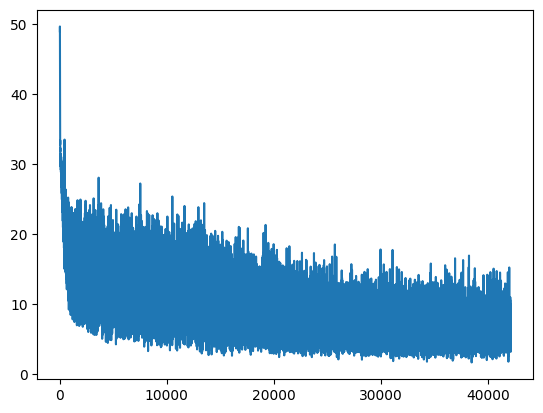

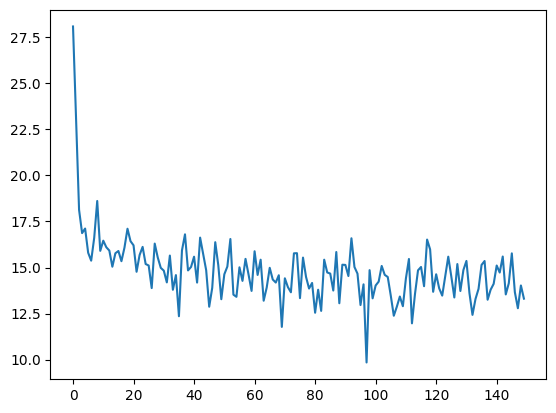

In [23]:
plt.plot(losses)
plt.show()
plt.plot(test_losses)
plt.show()